In [14]:
from matplotlib import rcParams
from utils import *
# 配置全局绘图参数
rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.dpi'] = 300

df = pd.read_excel("../datasets.xlsx")
X_train, X_test, ys_train, ys_test, mlb, x_scaler, feature_names = preprocess_data_class(df)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
species_model = AlgaeSpeciesClassifier(
    input_size=X_train.shape[1],
    num_species=len(mlb.classes_)
).to(device)
species_model.eval()

species_model.load_state_dict(torch.load('algae_species_model.pth'))

test_species_dataset = AlgaeSpeciesDataset(X_test, ys_test)
test_loader = DataLoader(test_species_dataset, batch_size=12)
train_species_dataset = AlgaeSpeciesDataset(X_train, ys_train)
train_loader = DataLoader(train_species_dataset, batch_size=102)
species_model.eval()
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from captum.attr import IntegratedGradients, LayerConductance
from captum.attr import visualization as viz
import matplotlib
def interpret_model(model, loader, mlb, feature_names, device, x_scaler, X, ys, num_samples=200):
    """
    执行全面的可解释性分析，包含：
    1. 全局特征重要性分析
    2. 类别特异性特征重要性
    3. 代表性样本分析
    """
    model.eval()
    ig = IntegratedGradients(model)

    # 获取测试样本
    batch = next(iter(loader))
    inputs = batch['features'].to(device)
    targets = batch['species'].cpu().numpy()

    # 创建解释结果存储结构
    class_names = mlb.classes_
    attribution_results = {
        'global': pd.DataFrame(columns=feature_names),
        'class_specific': {cls: pd.DataFrame(columns=feature_names)
                         for cls in class_names}
    }

    # ----------------------
    # 1. 全局特征重要性分析（维度修正）
    # ----------------------
    print("正在进行全局特征重要性分析...")
    all_attrs = []
    valid_samples = 0

    for i in range(min(num_samples, len(inputs))):
        input_tensor = inputs[i].unsqueeze(0).to(device)
        input_tensor.requires_grad_()

        # 获取当前样本的正例类别
        sample_targets = targets[i]
        positive_classes = np.where(sample_targets == 1)[0]

        # 跳过无正例的样本
        if len(positive_classes) == 0:
            print(f"样本 {i+1}/{len(inputs)} 无正例标签，跳过")
            continue

        # 计算归因
        attr_per_class = []
        for class_idx in positive_classes:
            try:
                attributions = ig.attribute(
                    input_tensor,
                    target=int(class_idx),
                    baselines=torch.zeros_like(input_tensor),
                    n_steps=50
                )
                # 确保归因结果保持正确维度
                attr_np = attributions.detach().cpu().numpy().squeeze(0)  # (1, n_feat) -> (n_feat,)
                attr_per_class.append(attr_np)
            except Exception as e:
                print(f"类别 {class_names[class_idx]} 归因计算失败: {str(e)}")
                continue

        # 处理有效归因结果
        if len(attr_per_class) > 0:
            try:
                # 计算平均归因（跨类别）
                mean_attrs = np.abs(np.mean(attr_per_class, axis=0))  # (n_features,)

                # 维度验证
                assert mean_attrs.shape[0] == len(feature_names), \
                    f"特征维度不匹配！{mean_attrs.shape} vs {len(feature_names)}"

                all_attrs.append(mean_attrs)
                valid_samples += 1
            except Exception as e:
                print(f"样本 {i+1} 处理失败: {str(e)}")

    # 计算全局重要性
    if valid_samples > 0:
        # 转换为二维数组 [n_samples, n_features]
        all_attrs_array = np.stack(all_attrs)
        global_importance = np.mean(all_attrs_array, axis=0)

        # 创建DataFrame
        attribution_results['global'] = pd.DataFrame(
            [global_importance],  # 注意保持二维结构
            columns=feature_names
        )
        print(f"全局重要性矩阵形状验证: {attribution_results['global'].shape}")
    else:
        print("警告：没有有效样本可用于全局分析")

    # ----------------------
    # 2. 类别特异性分析（增强版）
    # ----------------------
    print("\n正在进行类别特异性分析...")
    class_attrs = {cls: [] for cls in class_names}
    class_counts = {cls: 0 for cls in class_names}

    for i in range(min(num_samples, len(inputs))):
        input_tensor = inputs[i].unsqueeze(0).to(device)
        input_tensor.requires_grad_()

        sample_targets = targets[i]
        positive_classes = np.where(sample_targets == 1)[0]

        for class_idx in positive_classes:
            cls = class_names[class_idx]
            try:
                attributions = ig.attribute(
                    input_tensor,
                    target=int(class_idx),
                    baselines=torch.zeros_like(input_tensor),
                    n_steps=50
                )
                attr_np = attributions.detach().cpu().numpy().squeeze(0)  # [n_features,]
                class_attrs[cls].append(attr_np)
                class_counts[cls] += 1
            except Exception as e:
                print(f"类别 {cls} 样本 {i} 计算失败: {str(e)}")

    # 计算类别平均
    for cls in class_names:
        if class_counts[cls] > 0:
            avg_attr = np.mean(class_attrs[cls], axis=0)
            attribution_results['class_specific'][cls] = pd.DataFrame(
                [avg_attr], columns=feature_names
            )
        else:
            print(f"类别 {cls} 无有效样本，保留空DataFrame")

    # ----------------------
    # 可视化模块
    # ----------------------
    plot_global_importance(attribution_results['global'], feature_names)
    # 可视化模块（添加参数传递）
    plot_class_specific_heatmap(attribution_results['class_specific'],
                              class_names, feature_names,
                              x_scaler, X, ys, mlb)

    return attribution_results

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

def plot_global_importance(global_df, feature_names, top_n=15):
    """可视化全局特征重要性（专业优化版）"""
    plt.figure(figsize=(18, 10))
    sns.set_style("whitegrid")
    matplotlib.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['axes.edgecolor'] = '#4B4B4B'  # 坐标轴颜色

    # ======================
    # 数据处理
    # ======================
    sorted_idx = np.argsort(global_df.values[0])[::1]
    sorted_features = [feature_names[i] for i in sorted_idx][:top_n]
    sorted_values = global_df.values[0][sorted_idx][:top_n]

    # ======================
    # 视觉设计参数
    # ======================
    COLOR_MAP = plt.cm.coolwarm  # 使用coolwarm色系
    GRADIENT_RANGE = (0.15, 0.85)  # 调整渐变区间增强对比
    BAR_HEIGHT = 0.7
    EDGE_WIDTH = 1.2

    # ======================
    # 颜色生成
    # ======================
    color_values = np.linspace(*GRADIENT_RANGE, len(sorted_features))
    colors = [COLOR_MAP(v) for v in color_values[::-1]]  # 反转颜色

    # ======================
    # 绘制条形图
    # ======================
    bars = plt.barh(sorted_features[::-1], sorted_values[::-1],
                    color=colors,
                    edgecolor='#2F4F4F',  # 深石板灰边框
                    linewidth=EDGE_WIDTH,
                    height=BAR_HEIGHT,
                    alpha=0.9)  # 轻微透明效果

    # ======================
    # 数据标签优化
    # ======================
    for bar in bars:
        width = bar.get_width()
        plt.text(width * 1.03,  # 调整间距
                bar.get_y() + bar.get_height()/2,
                f'{width:.2f}',
                va='center',
                ha='left',
                fontsize=12,
                fontweight='medium',
                fontfamily='Times New Roman',
                color='#2F4F4F',  # 深灰色文字
                bbox=dict(  # 添加文字背景框
                    boxstyle="round,pad=0.3",
                    facecolor=(1,1,1,0.8),  # 半透明白色
                    edgecolor=(0.8,0.8,0.8,0.5),
                    linewidth=0.5
                ))

    # ======================
    # 坐标轴与标签美化
    # ======================
    ax = plt.gca()
    ax.set_facecolor('#FAFAFA')  # 浅灰背景

    # 标题设置
    plt.title('Global Feature Importance Analysis\nAlgal Species Prediction',
             fontsize=26,
             fontweight='bold',  # 更重的字重
             pad=20,
             color='#2F4B4F',  # 与边框色系统一
             loc='left',
             )  # 左对齐

    # # 坐标轴标签
    # plt.xlabel('Average Attribution Value',
    #           fontsize=16,
    #           labelpad=12,
    #           fontweight='medium',
    #           color='#4B4B4B')
    #
    # plt.ylabel('Environmental Features',
    #           fontsize=16,
    #           labelpad=12,
    #           fontweight='medium',
    #           color='#4B4B4B')

    # 刻度标签
    plt.xticks(fontsize=20, color='#6B6B6B',
              fontweight='medium',)
    plt.yticks(fontsize=20, color='#4B4B4B', fontweight='medium')

    # ======================
    # 网格与边框优化
    # ======================
    ax.xaxis.grid(True,
                linestyle='--',
                linewidth=0.8,
                alpha=0.4,
                color='#B0B0B0')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('#808080')
    ax.spines['left'].set_color('#808080')

    # ======================
    # 布局与输出
    # ======================
    plt.gca().invert_yaxis()  # 保持降序排列
    plt.tight_layout(pad=3)  # 增加边距

    # 保存为透明背景
    plt.savefig('global_importance.png',
               dpi=350,  # 更高分辨率
               bbox_inches='tight',
               transparent=False)
    plt.close()

def plot_class_specific_heatmap(class_data, class_names, feature_names,
                               x_scaler, X, ys, mlb, top_n=20):
    """可视化类别特异性特征重要性热图（增强版样式）"""
    # 初始化图形（增大画布尺寸以适应更大字体）
    plt.figure(figsize=(20, 14))
    sns.set(font_scale=1.2)  # 调大字体缩放系数
    sns.set_style("whitegrid")
    matplotlib.rcParams['font.family'] = 'Times New Roman'

    # ======================
    # 1. 确定全局特征排序
    # ======================
    # 计算全局平均重要性
    global_importance = np.zeros(len(feature_names))
    valid_classes = 0

    for cls in class_names:
        if not class_data[cls].empty:
            global_importance += class_data[cls].values[0]
            valid_classes += 1

    if valid_classes > 0:
        global_importance /= valid_classes
    else:
        raise ValueError("没有有效的类别数据进行可视化")

    # 获取全局top特征索引
    global_top_indices = np.argsort(global_importance)[::-1][:top_n]
    global_features = [feature_names[i] for i in global_top_indices]

    # ======================
    # 2. 数据准备
    # ======================
    heatmap_data = []
    annot_data = []
    cls_labels = []

    for cls in class_names:
        if not class_data[cls].empty:
            # 按全局特征顺序获取数据
            cls_values = []
            cls_annot = []

            # 获取当前类别的重要性值
            raw_values = class_data[cls].values[0]

            # 获取反归一化统计量
            class_idx = mlb.classes_.tolist().index(cls)
            mask = ys[:, class_idx] == 1
            X_cls = X[mask]

            # 反归一化处理
            if len(X_cls) > 0:
                X_original = x_scaler.inverse_transform(X_cls)
                means = X_original.mean(axis=0)
                stds = X_original.std(axis=0)
            else:
                means = np.full(len(feature_names), np.nan)
                stds = np.full(len(feature_names), np.nan)

            # 按全局特征顺序填充数据
            for feat_idx in global_top_indices:
                # 重要性值
                importance = raw_values[feat_idx]
                cls_values.append(importance)

                # 统计量注释
                if np.isnan(means[feat_idx]):
                    annot_str = f"{importance:.2f}\n(-)"
                else:
                    annot_str = f"{importance:.2f}\n({means[feat_idx]:.1f}±{stds[feat_idx]:.1f})"
                cls_annot.append(annot_str)

            heatmap_data.append(cls_values)
            annot_data.append(cls_annot)
            cls_labels.append(cls)

    # ======================
    # 3. 创建数据框
    # ======================
    df = pd.DataFrame(
        heatmap_data,
        index=cls_labels,
        columns=global_features
    )
    annot_df = pd.DataFrame(
        annot_data,
        index=cls_labels,
        columns=global_features
    )

    # 3. 可视化参数增强
    # ======================
    # 创建子图时增加高度比例
    fig, ax = plt.subplots(figsize=(26, 16))
        # ======================
    # 6. 标题样式增强
    # ======================
    ax.set_title(
        "Class-Specific Environment Feature Importance with distribution\n"
        "(Upper: Features Importance, Lower: Features Distribution Mean±SD)",
        fontsize=32,  # 调大标题字号
        fontweight='heavy',  # 更重的字重
        pad=25,
        color='#2F4F4F',
        loc='center'
        # 左对齐
    )

    # 自定义颜色映射（增强对比度）
    cmap = plt.cm.viridis
    cmap = plt.cm.coolwarm
    cmap.set_bad('#FFD700')  # 设置缺失值颜色为金色

    # 绘制热力图（增强注释样式）
    sns.heatmap(
        df.T,
        cmap=cmap,
        annot=annot_df.T.values,
        fmt="s",
        linewidths=0.8,  # 加粗单元格边界
        linecolor='w',   # 设置边界线为白色
        annot_kws={
            "size": 20,  # 调大注释字体
            "weight": "bold",  # 加粗字体
            "fontfamily": "Times New Roman",
            "color": "black",  # 亮黄色
            "linespacing": 1.5,
            "bbox": dict(  # 添加文字背景框
                boxstyle="round,pad=0.2",
                facecolor="white",  # 黑色背景
                edgecolor="none",
                alpha=0.5
            )
        },
        cbar_kws={
            "label": "Feature Importance",
            "shrink": 0.7,
            "aspect": 30,
            "pad": 0.02
        },
        ax=ax
    )

    # ======================
    # 4. 坐标轴样式增强
    # ======================
    # X轴标签样式
    plt.xticks(
        rotation=45,
        ha='right',
        fontsize=26,  # 调大字号
        fontweight='medium',  # 加粗
        color='#2F4F4F'  # 深石板灰
    )

    # Y轴标签样式
    plt.yticks(
        rotation=0,
        fontsize=26,  # 调大字号
        fontweight='medium',  # 加粗
        color='#2F4F4F'  # 深石板灰
    )

    # ======================
    # 5. 颜色条样式增强
    # ======================
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(
        labelsize=22,  # 调大刻度标签
        width=2,       # 加粗刻度线
        length=10,      # 加长刻度线
        colors='#2F4F4F'  # 刻度颜色
    )
    cbar.set_label(
        "Normalized Importance Score",
        fontsize=22,  # 调大标签字号
        fontweight='medium',
        color='#2F4F4F',
        labelpad=15
    )

    # ======================
    # 7. 背景优化
    # ======================
    # 设置背景颜色
    fig.patch.set_facecolor('#F5F5F5')  # 浅灰色背景
    ax.set_facecolor('#FAFAD2')  # 浅金色背景

    # 调整布局并保存
    plt.tight_layout(pad=3)  # 增加边距
    plt.savefig(
        'enhanced_heatmap.png',
        dpi=300,
        bbox_inches='tight',
        facecolor=fig.get_facecolor()  # 保持背景一致
    )
    plt.close()




# 调用解释器时添加新参数
attribution_results = interpret_model(
    model=species_model,
    loader=train_loader,
    mlb=mlb,
    feature_names=feature_names,
    device=device,
    x_scaler=x_scaler,
    X=X_train,
    ys=ys_train,
    num_samples=150
)

原始数据形状: (114, 14)
过滤后藻类种类标签数量: 7
正在进行全局特征重要性分析...
样本 26/102 无正例标签，跳过
样本 28/102 无正例标签，跳过
样本 73/102 无正例标签，跳过
样本 85/102 无正例标签，跳过
全局重要性矩阵形状验证: (1, 12)

正在进行类别特异性分析...


<Figure size 6000x4200 with 0 Axes>

In [13]:

import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_sample_attribution(i, input_tensor, model, ig, class_names,
                            feature_names, device, x_scaler,
                            top_k=200):
    """单个样本的可视化解释（整合特征值到Y轴标签）"""
    # 确保输入张量形状正确
    if input_tensor.dim() == 1:
        input_tensor = input_tensor.unsqueeze(0)
    input_tensor = input_tensor.to(device).requires_grad_(True)

    # 反归一化获取原始数值
    with torch.no_grad():
        original_values = x_scaler.inverse_transform(
            input_tensor.cpu().numpy().reshape(1, -1)
        )[0]

    # 获取预测结果
    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.45).cpu().numpy()[0]

    # 确定有效预测类别
    pred_indices = np.where(preds == 1)[0]

    if len(pred_indices) == 0:
        print("⚠️ 该样本无预测类别，跳过可视化")
        return

    # 按概率排序预测类别
    sorted_indices = sorted(pred_indices,
                            key=lambda x: probs.squeeze(0)[x].item(),
                            reverse=True)
    top_classes = [(class_names[i], probs.squeeze(0)[i].item())
                   for i in sorted_indices[:top_k]]

    # 创建可视化布局
    fig = plt.figure(figsize=(14, 3.5*len(top_classes)))
    gs = fig.add_gridspec(len(top_classes), 1)

    baseline = torch.zeros_like(input_tensor)

    for idx, (cls_name, prob) in enumerate(top_classes):
        ax = fig.add_subplot(gs[idx])

        # 计算归因
        try:
            attributions = ig.attribute(input_tensor,
                                        target=int(sorted_indices[idx]),
                                        baselines=baseline)
            attrs = attributions.squeeze(0).cpu().detach().numpy()
        except Exception as e:
            print(f"计算归因时出错: {str(e)}")
            raise

        # 生成带数值的特征标签
        sorted_indices_attr = np.argsort(np.abs(attrs))[::-1][:15]
        combined_labels = [
            f"{feature_names[i]}: {original_values[i]:.1f}"  # 名称与数值组合
            for i in sorted_indices_attr
        ]
        sorted_values = attrs[sorted_indices_attr]

        # 颜色映射（正负不同颜色，越极端越深）
        cmap = plt.cm.bwr  # 蓝红渐变色
        norm = plt.Normalize(vmin=-max(abs(sorted_values)), vmax=max(abs(sorted_values)))
        colors = cmap(norm(sorted_values))

        # 绘制条形图（标签反向排序以匹配数据）
        bars = ax.barh(
            combined_labels[::-1],  # 使用组合标签
            sorted_values[::-1],
            color=colors[::-1],
            height=0.8  # 调整条带高度
        )

        # 仅显示归因值标签
        for bar, attr_val in zip(bars, sorted_values[::-1]):
            width = bar.get_width()
            ax.text(width * 1.02 if width > 0 else width * 0.98,
                    bar.get_y() + bar.get_height()/2,
                    f"{attr_val:.2f}",
                    va='center',
                    ha='left' if width >= 0 else 'right',
                    fontsize=10,
                    fontfamily='Times New Roman')

        # 添加颜色条
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
        cbar.set_label("Attribution Value", fontsize=10)

        # 图表美化
        ax.set_title(f"Class: {cls_name} (Probability: {prob:.2f})",
                     fontsize=22, pad=12, fontweight='bold')
        ax.axvline(0, color='black', linewidth=0.8)
        ax.grid(axis='x', linestyle='--', alpha=0.6)
        ax.tick_params(axis='y', labelsize=10)  # 调整Y轴字体大小

        # 自动调整边距防止标签截断
        plt.subplots_adjust(left=0.4)

    plt.tight_layout()
    plt.savefig(f'sample_attribution_integrated_labels_{i}.png', dpi=300, bbox_inches='tight')


species_model.eval()
ig = IntegratedGradients(species_model)
class_names = mlb.classes_
# 获取测试样本
batch = next(iter(test_loader))
inputs = batch['features'].to(device)
# 调用时添加x_scaler参数

⚠️ 该样本无预测类别，跳过可视化


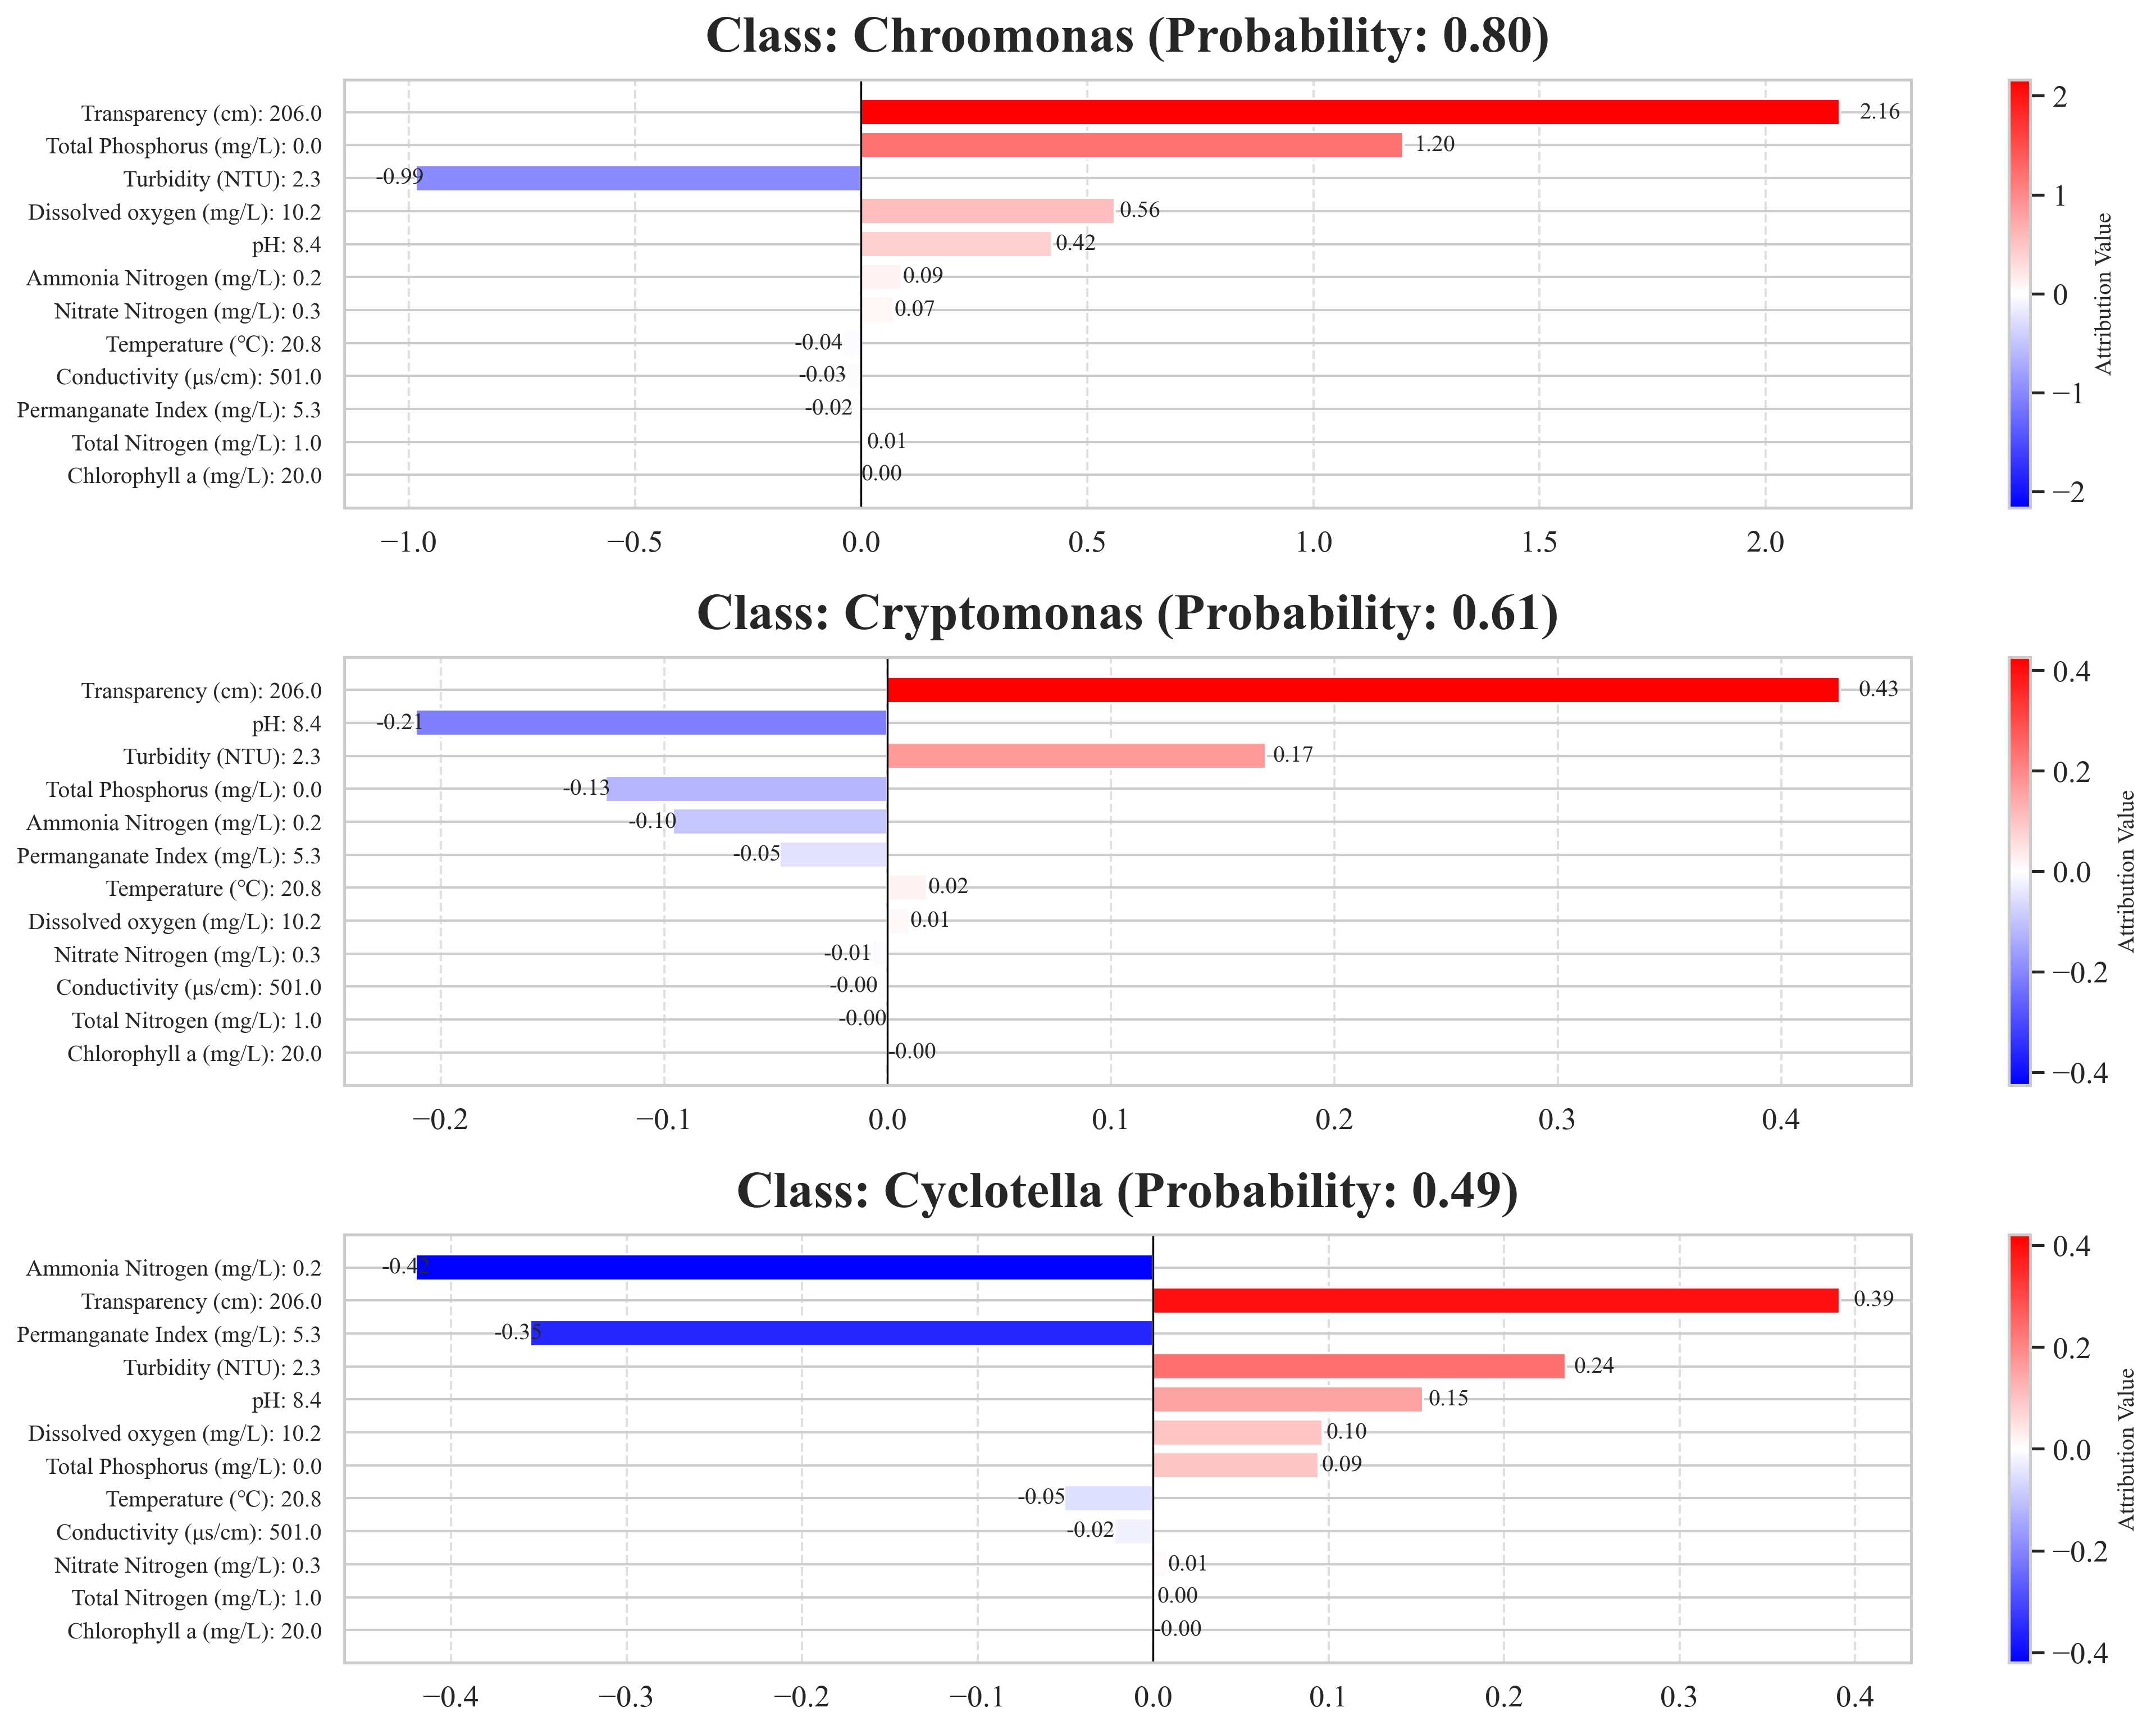

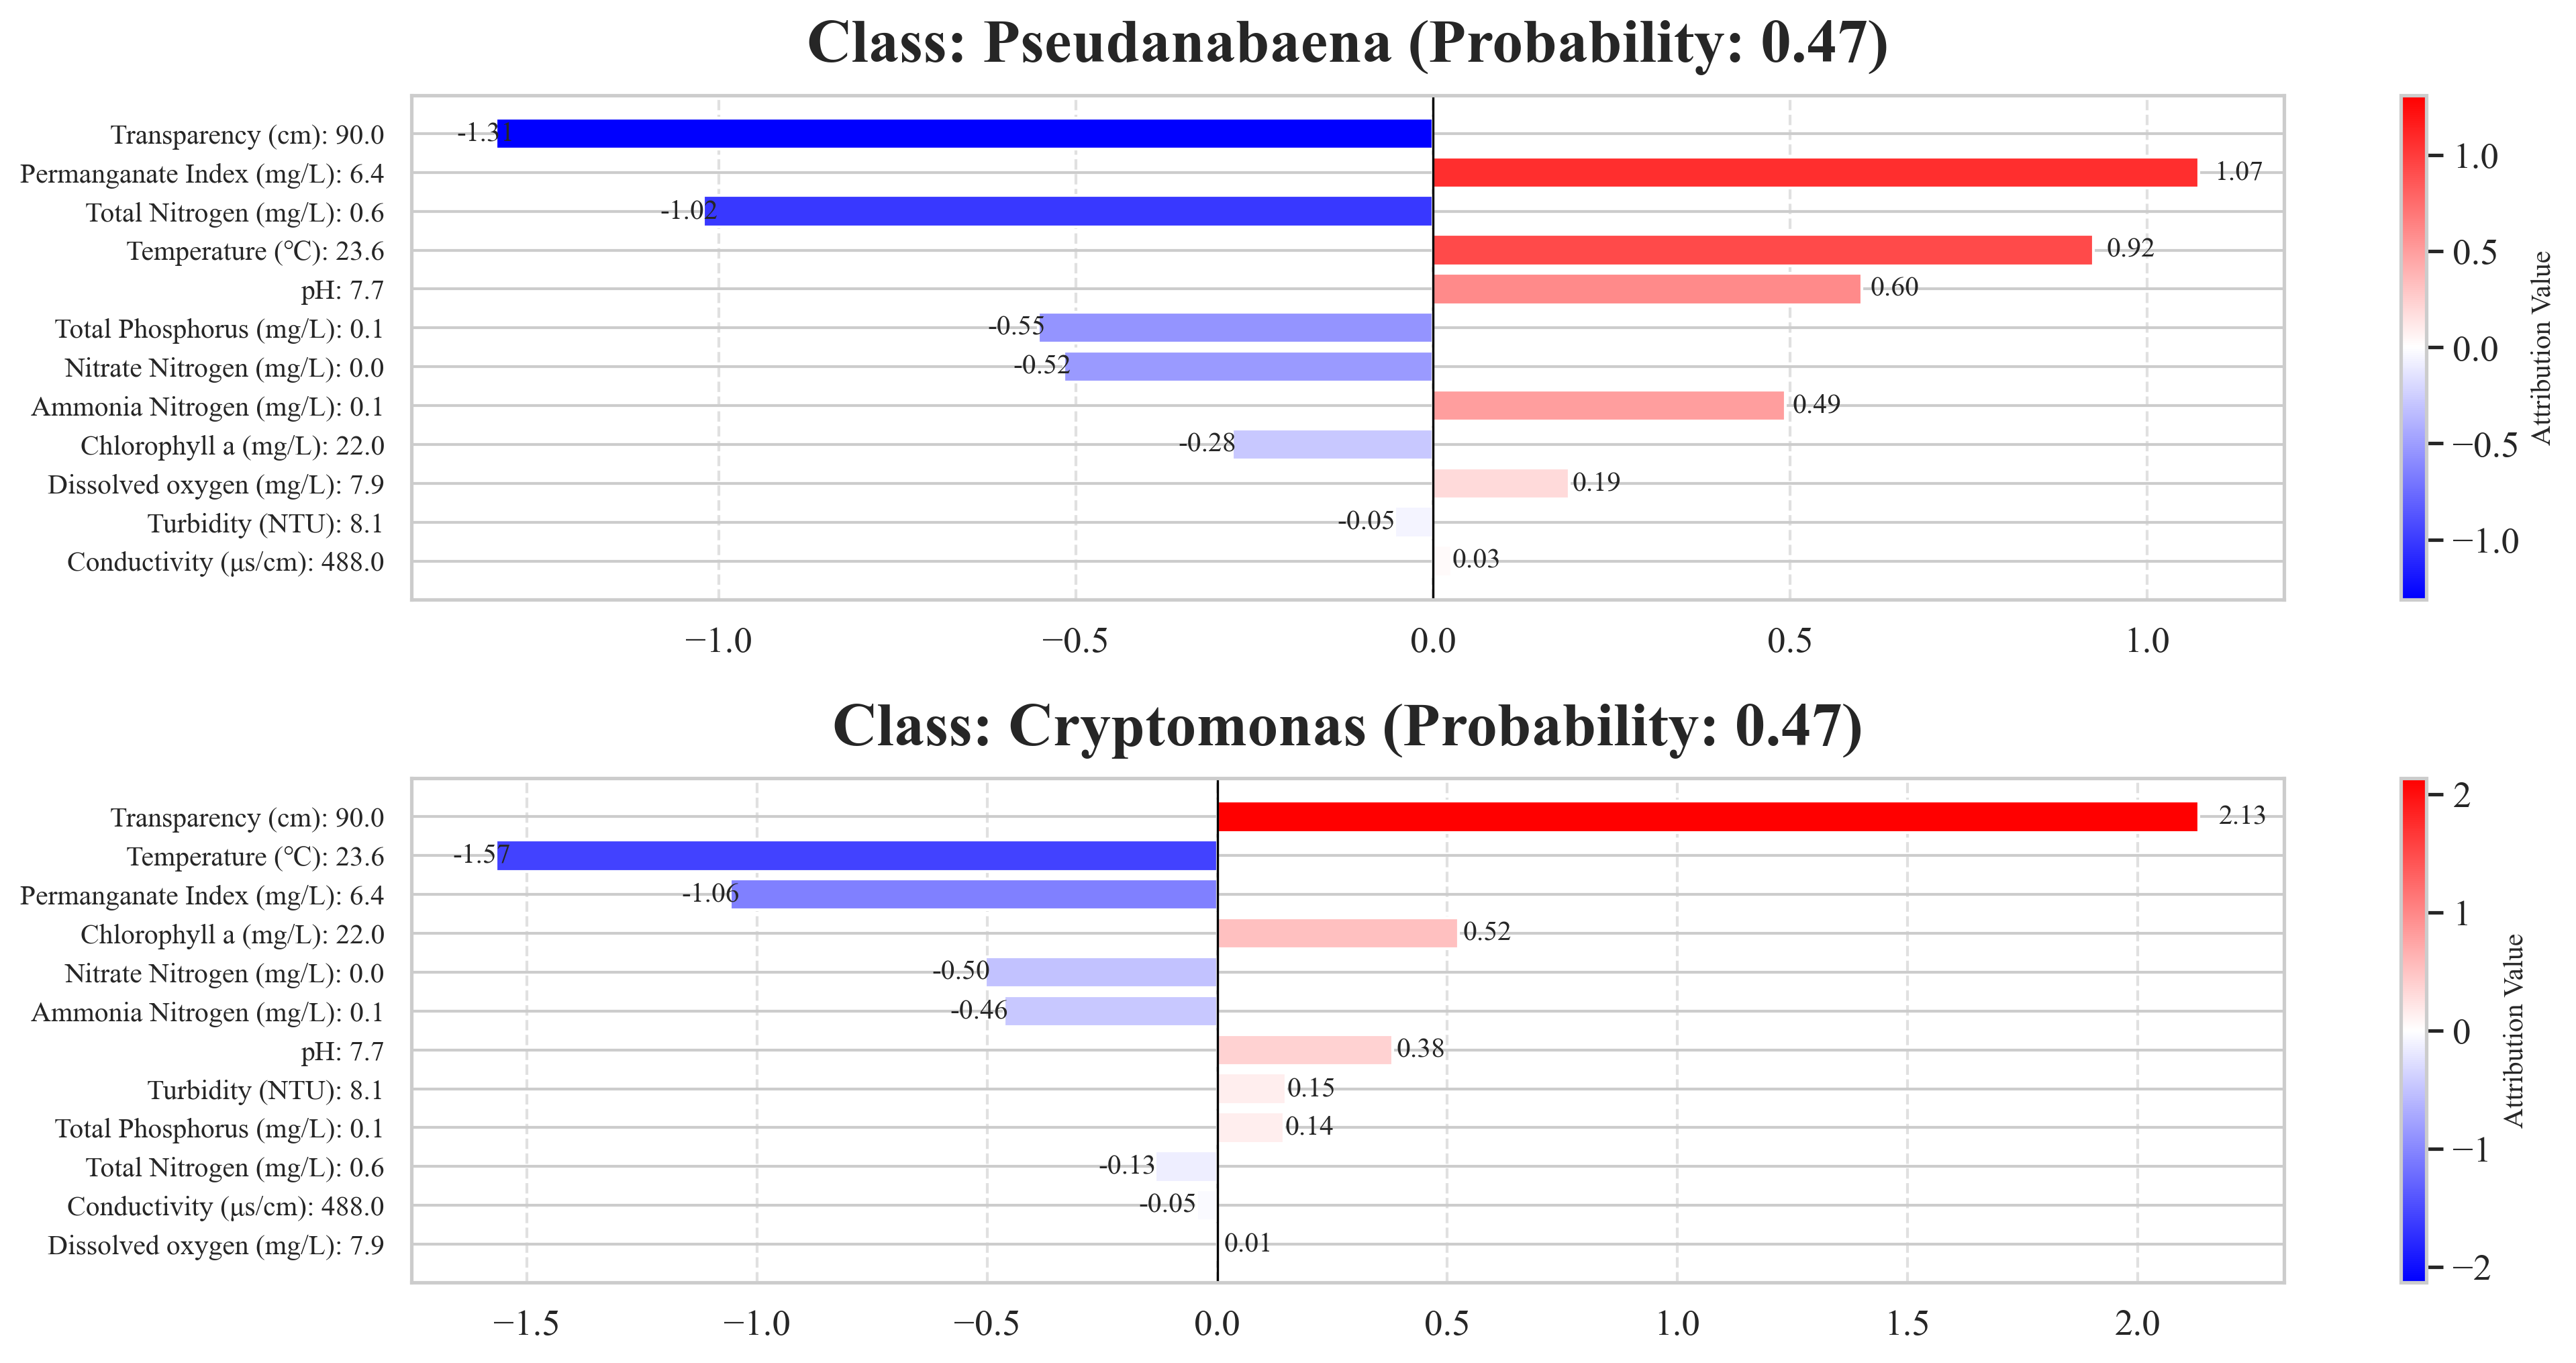

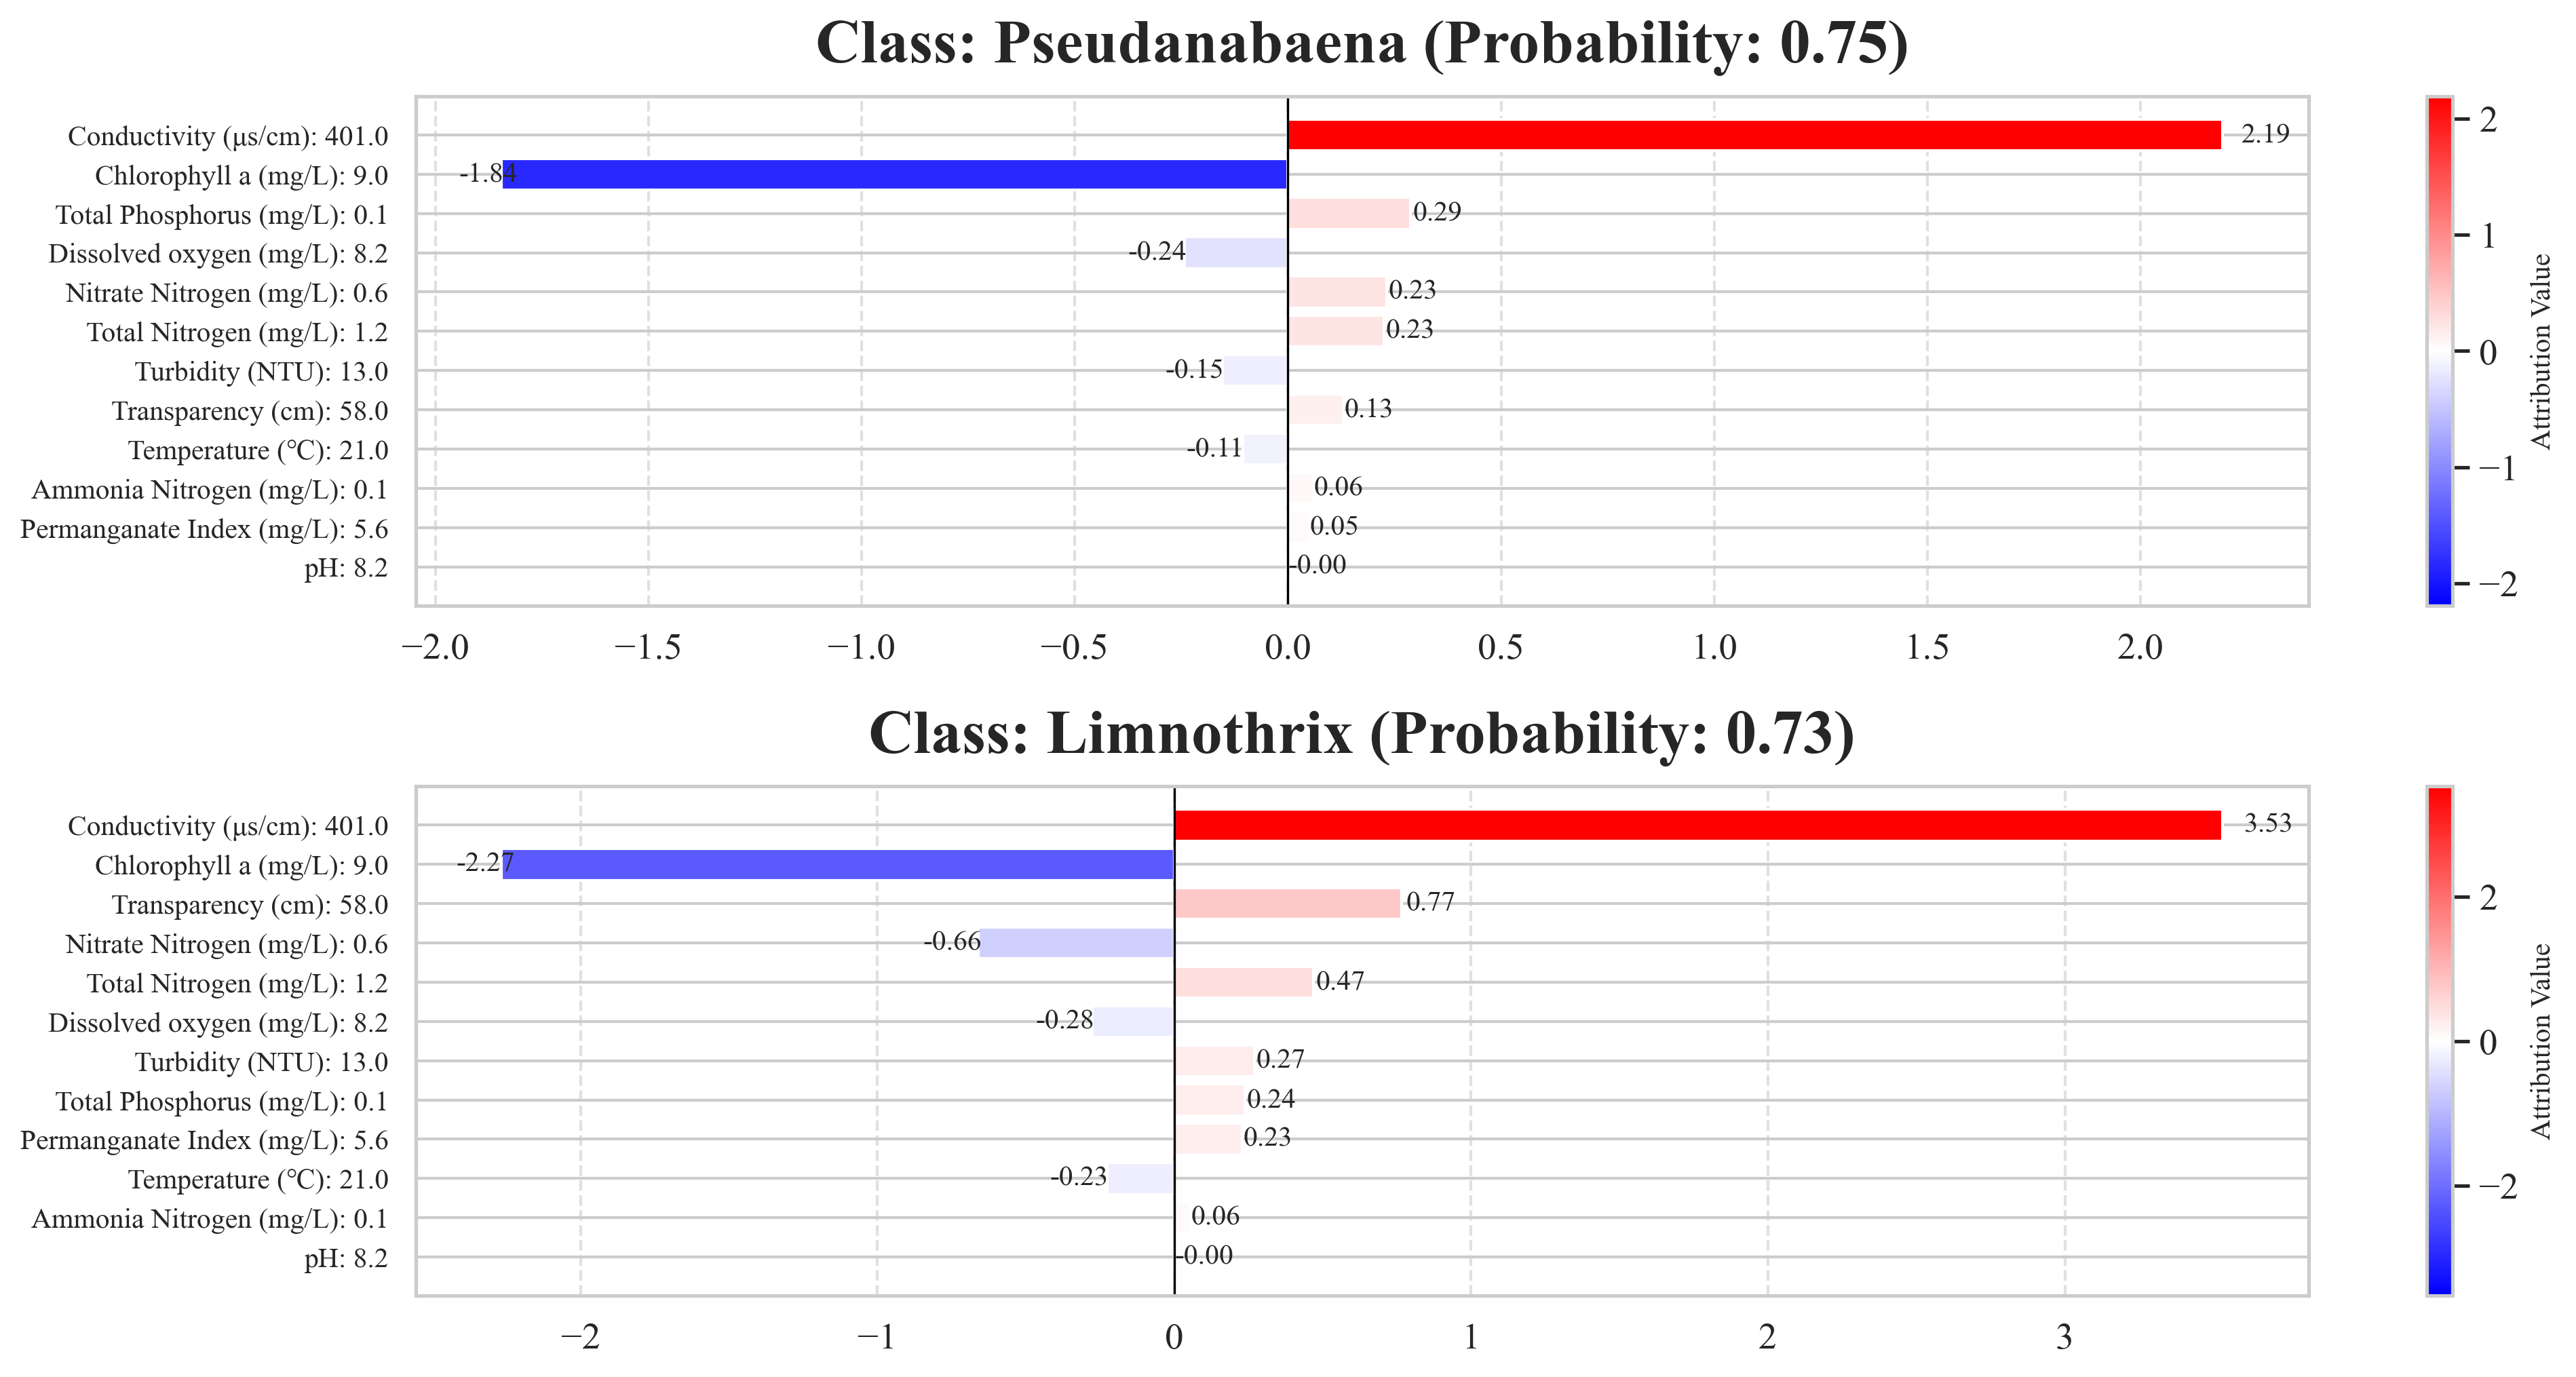

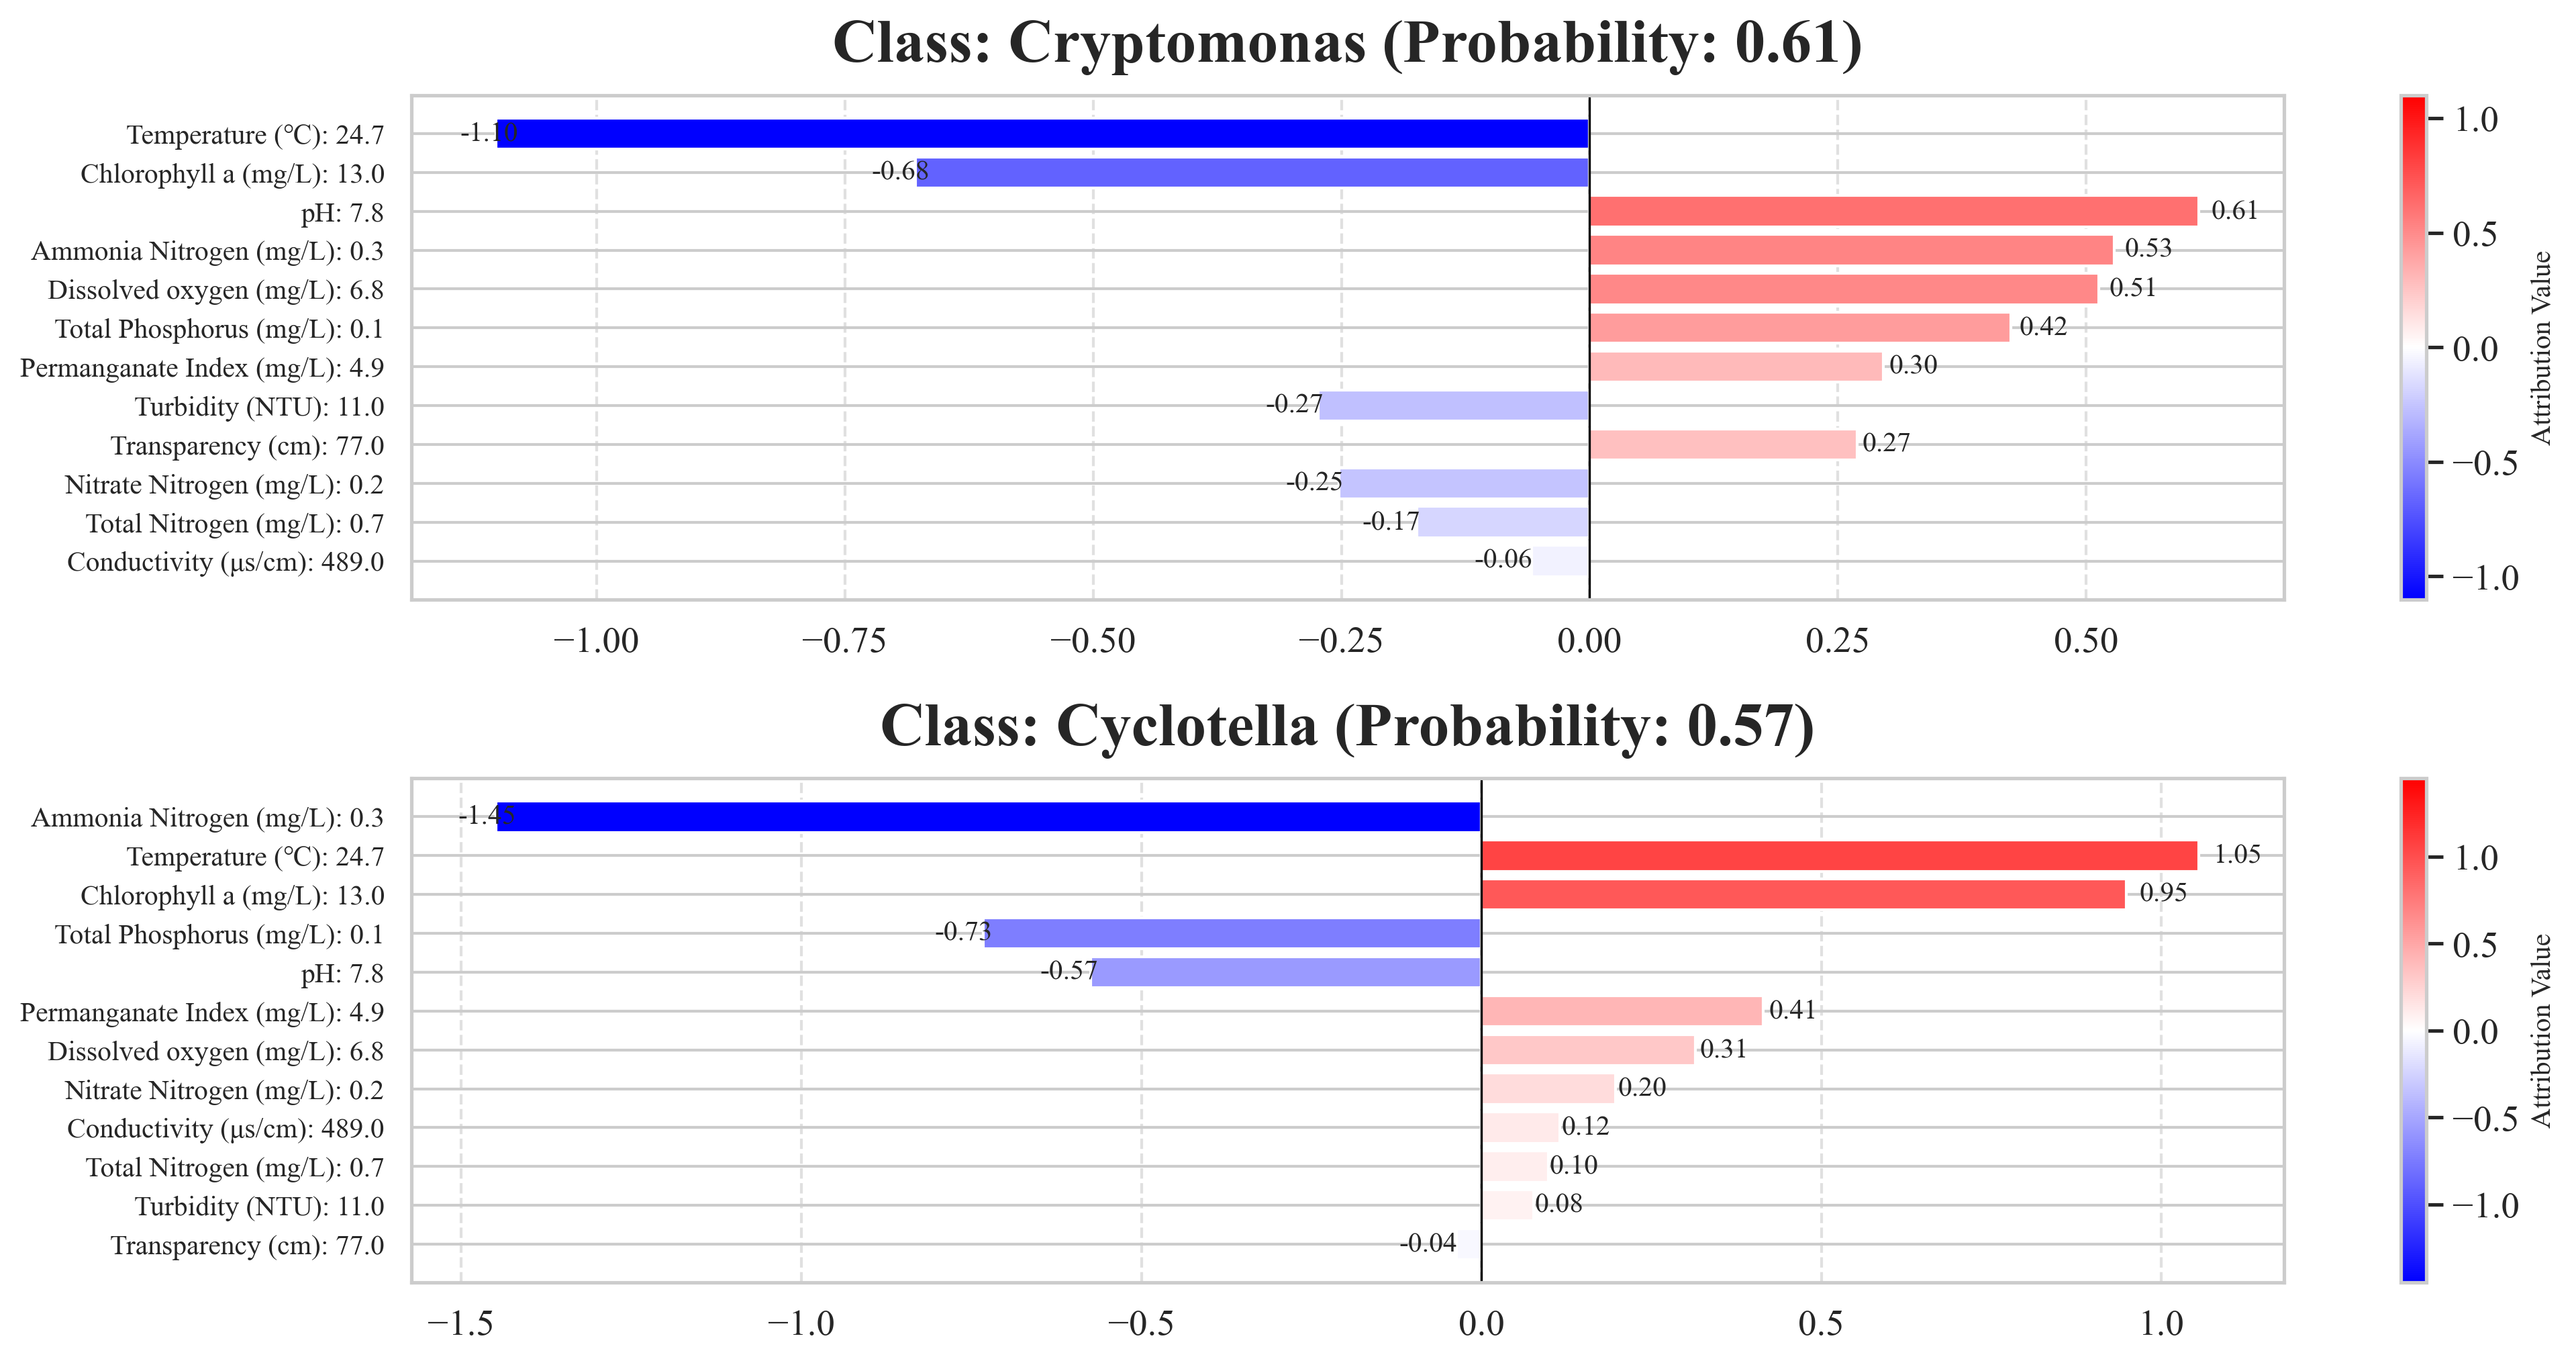

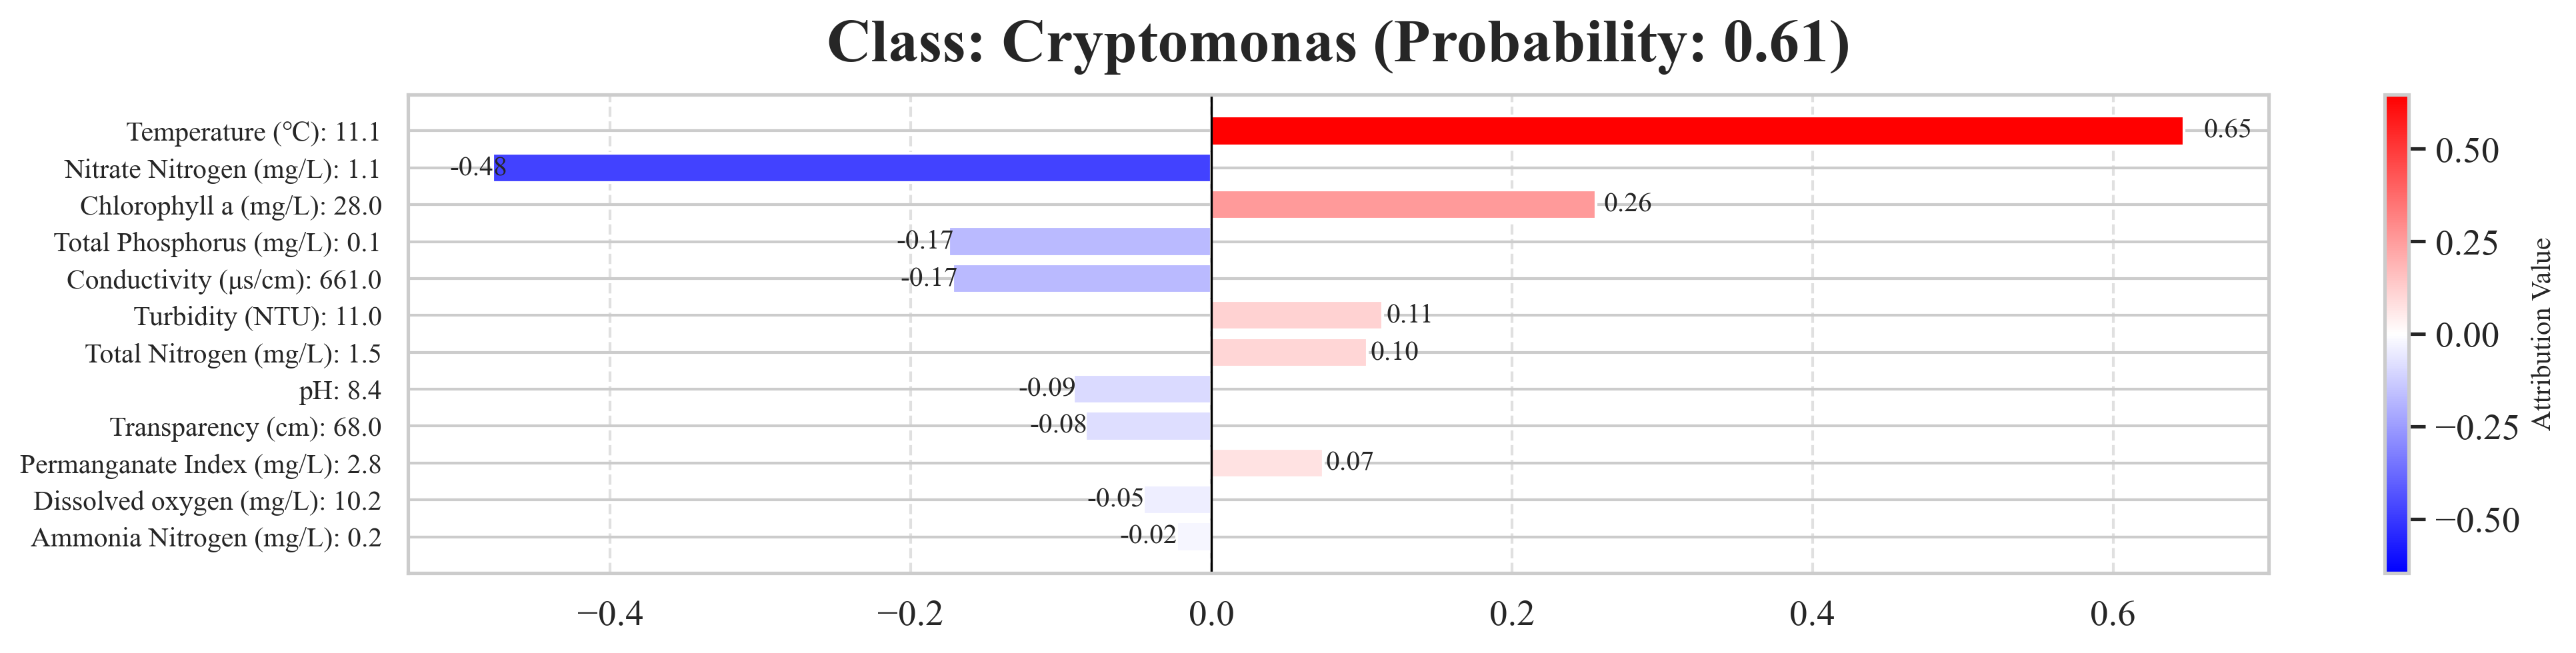

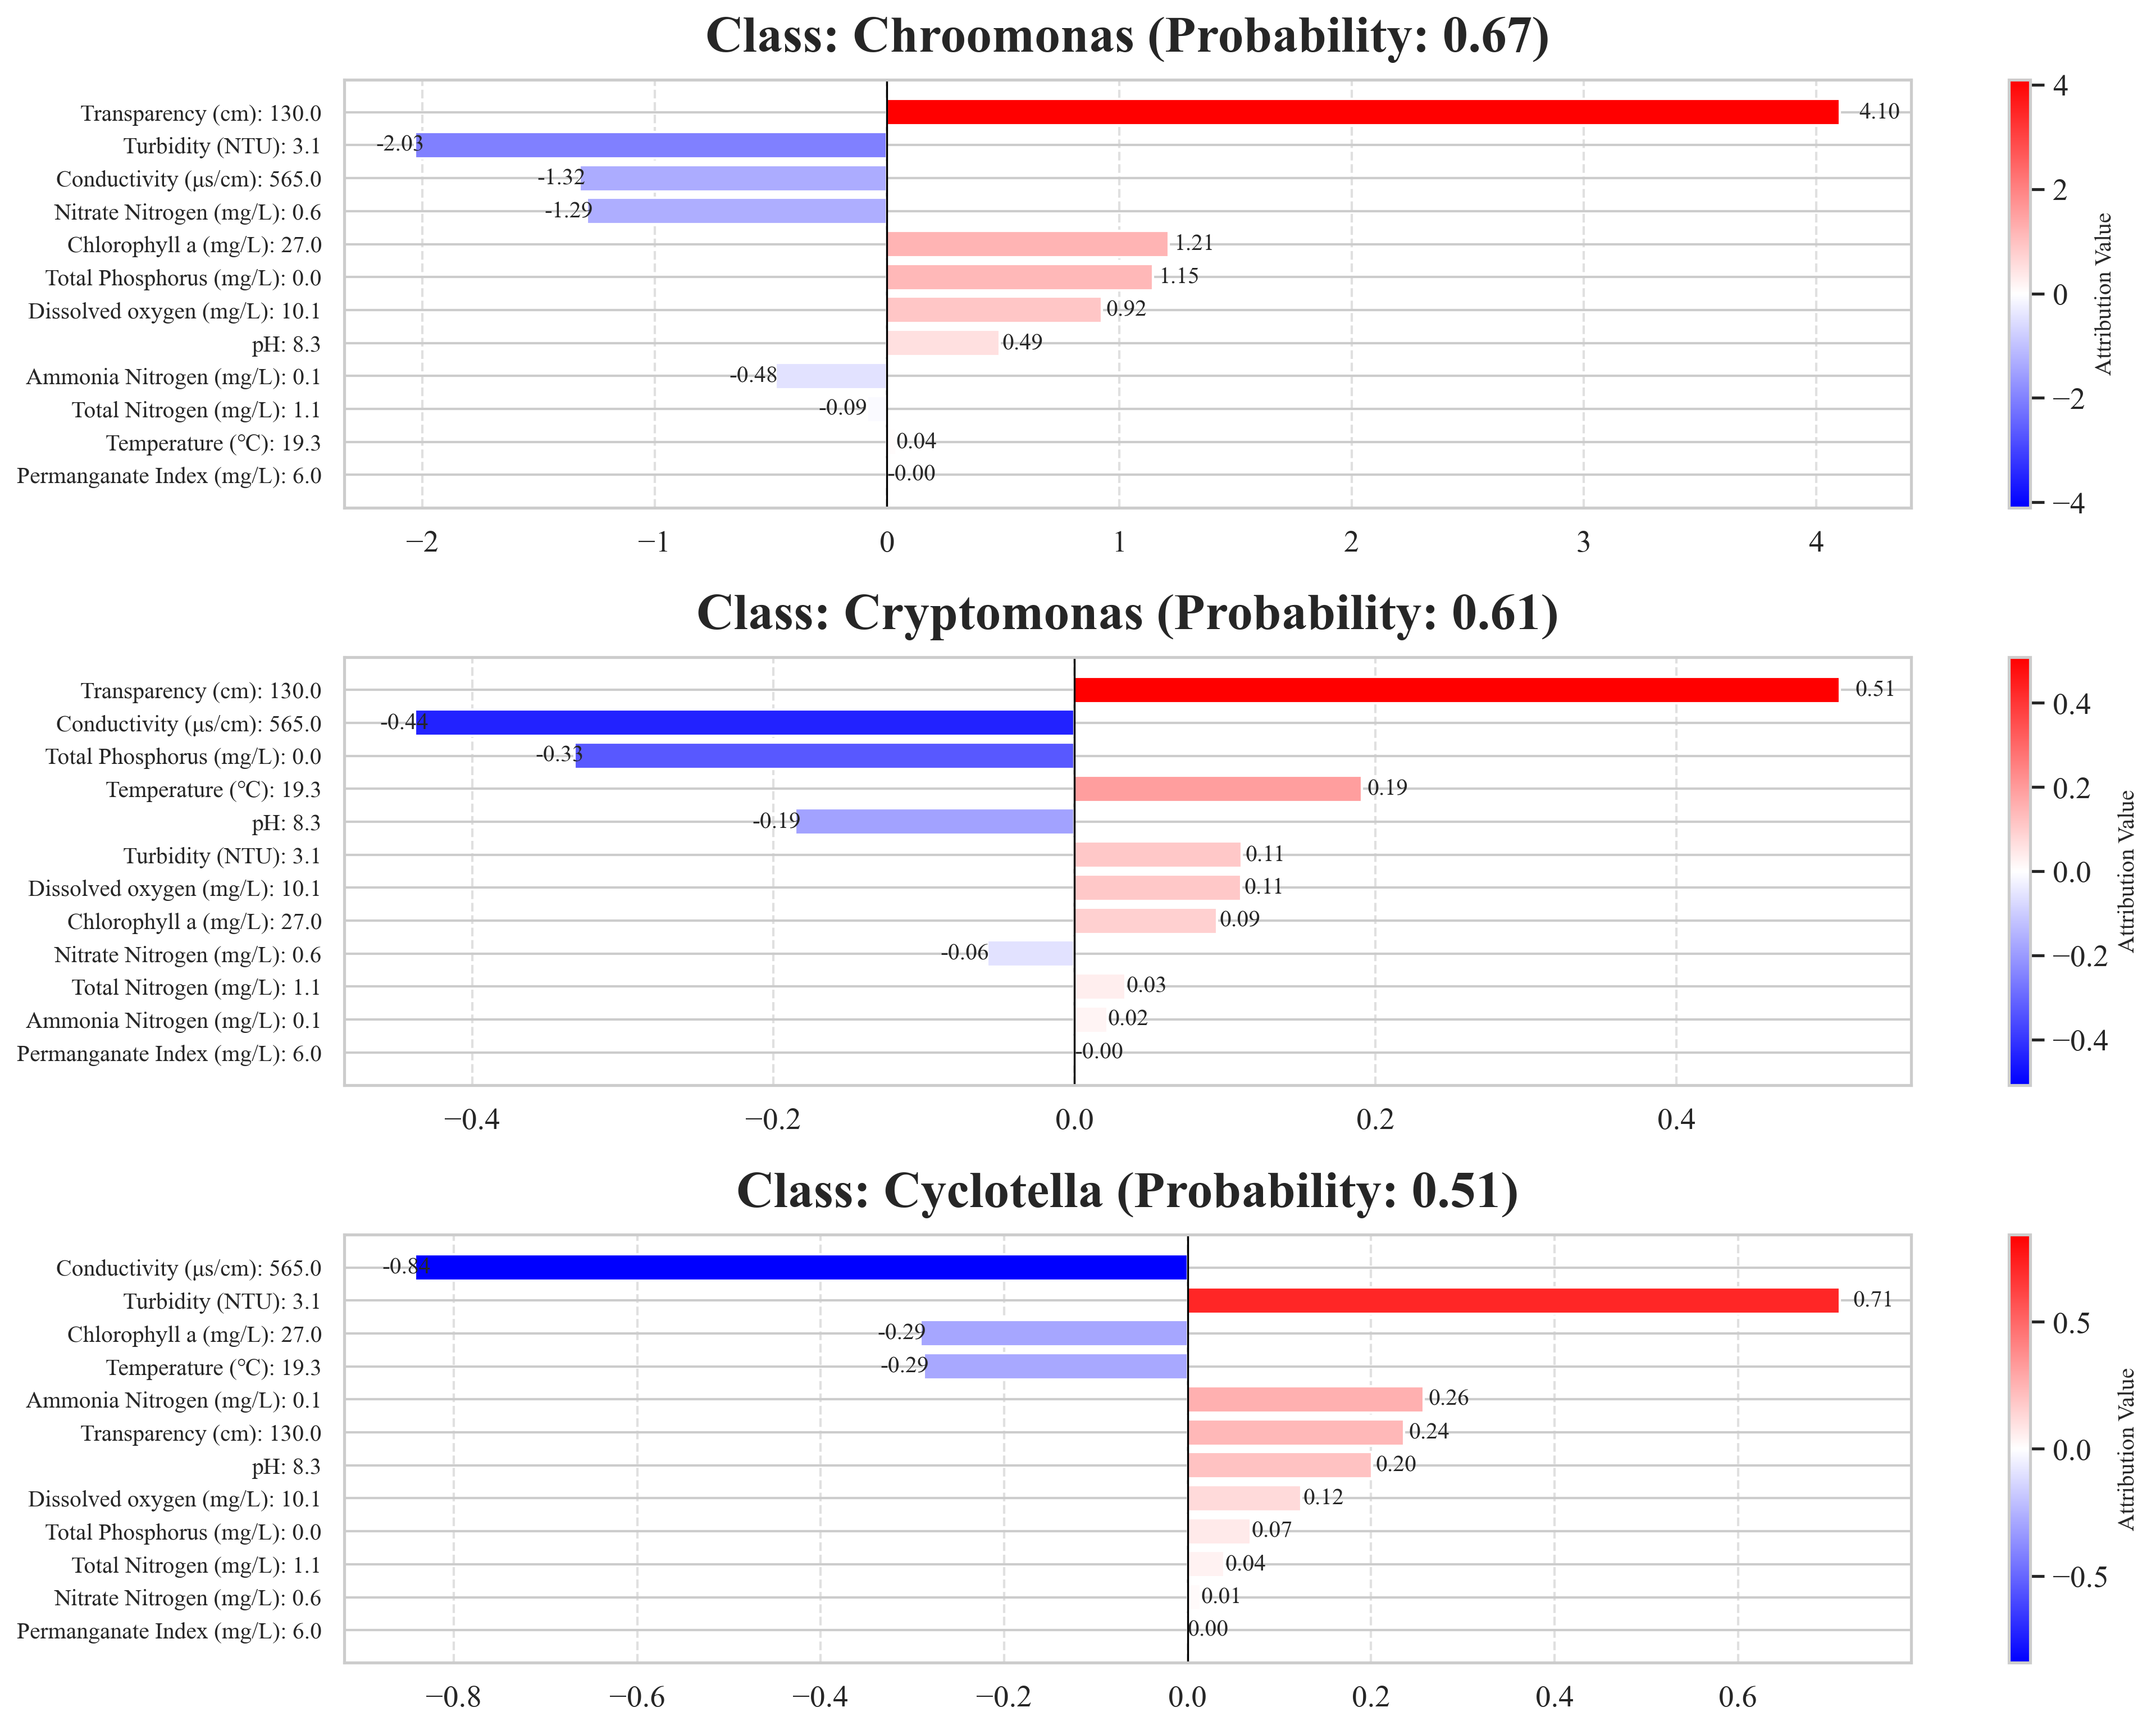

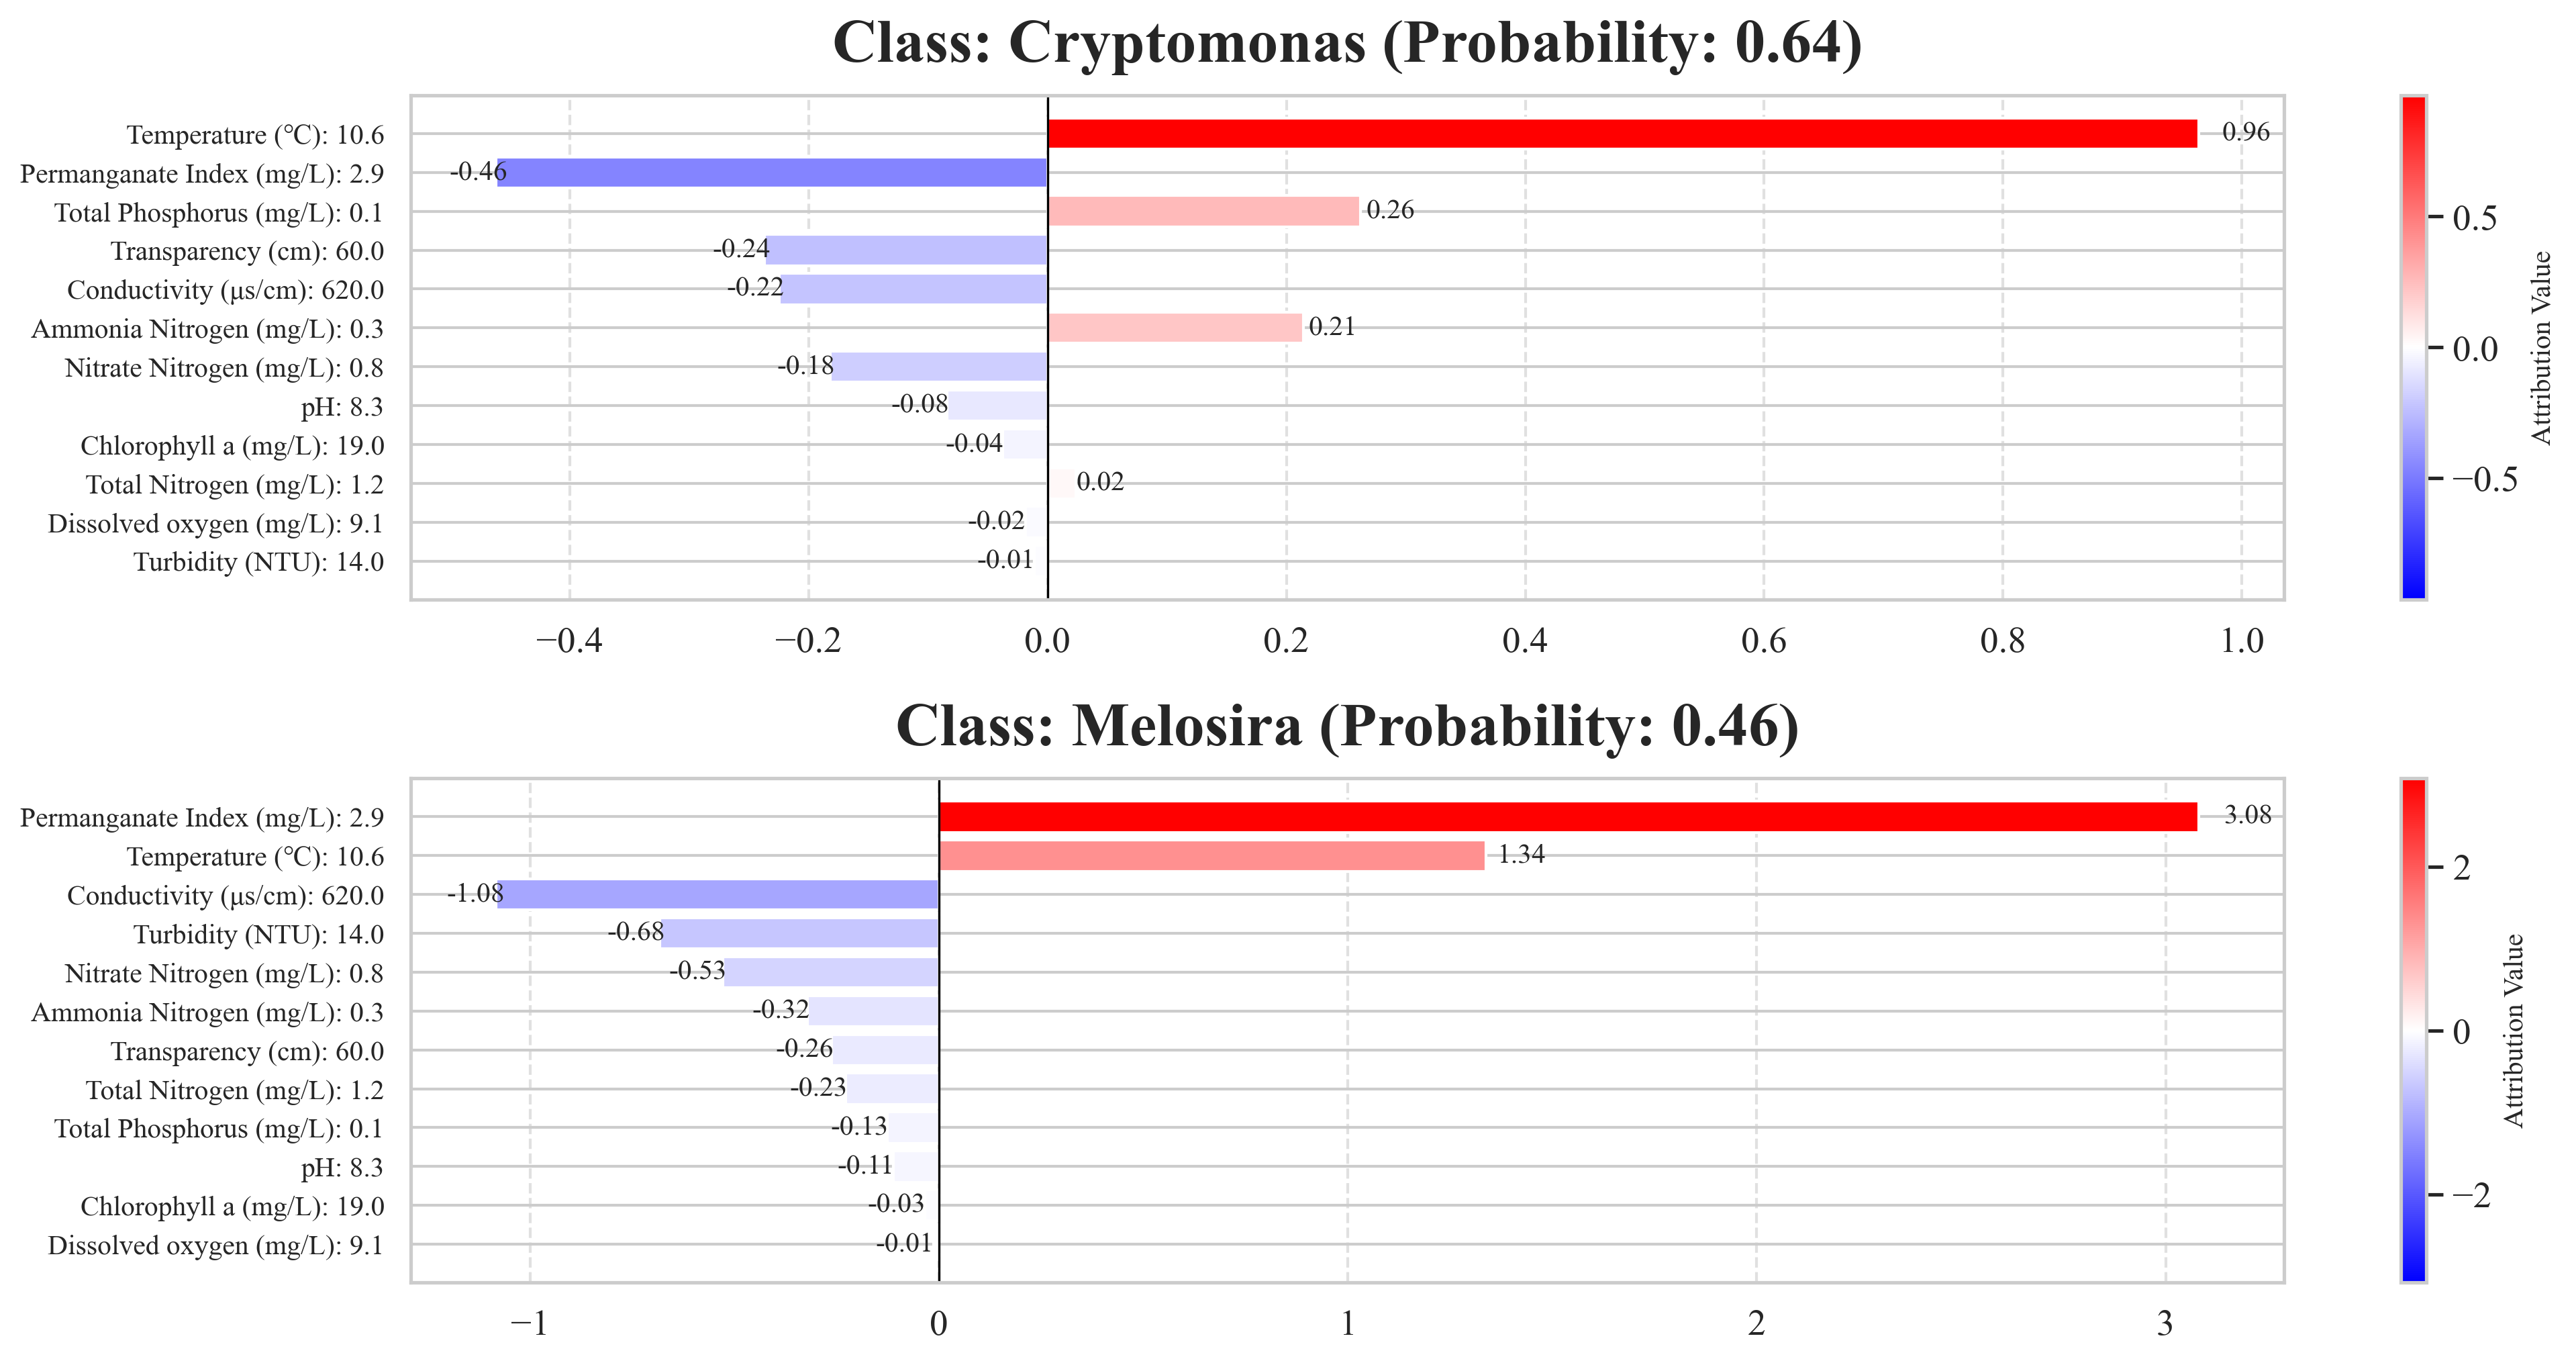

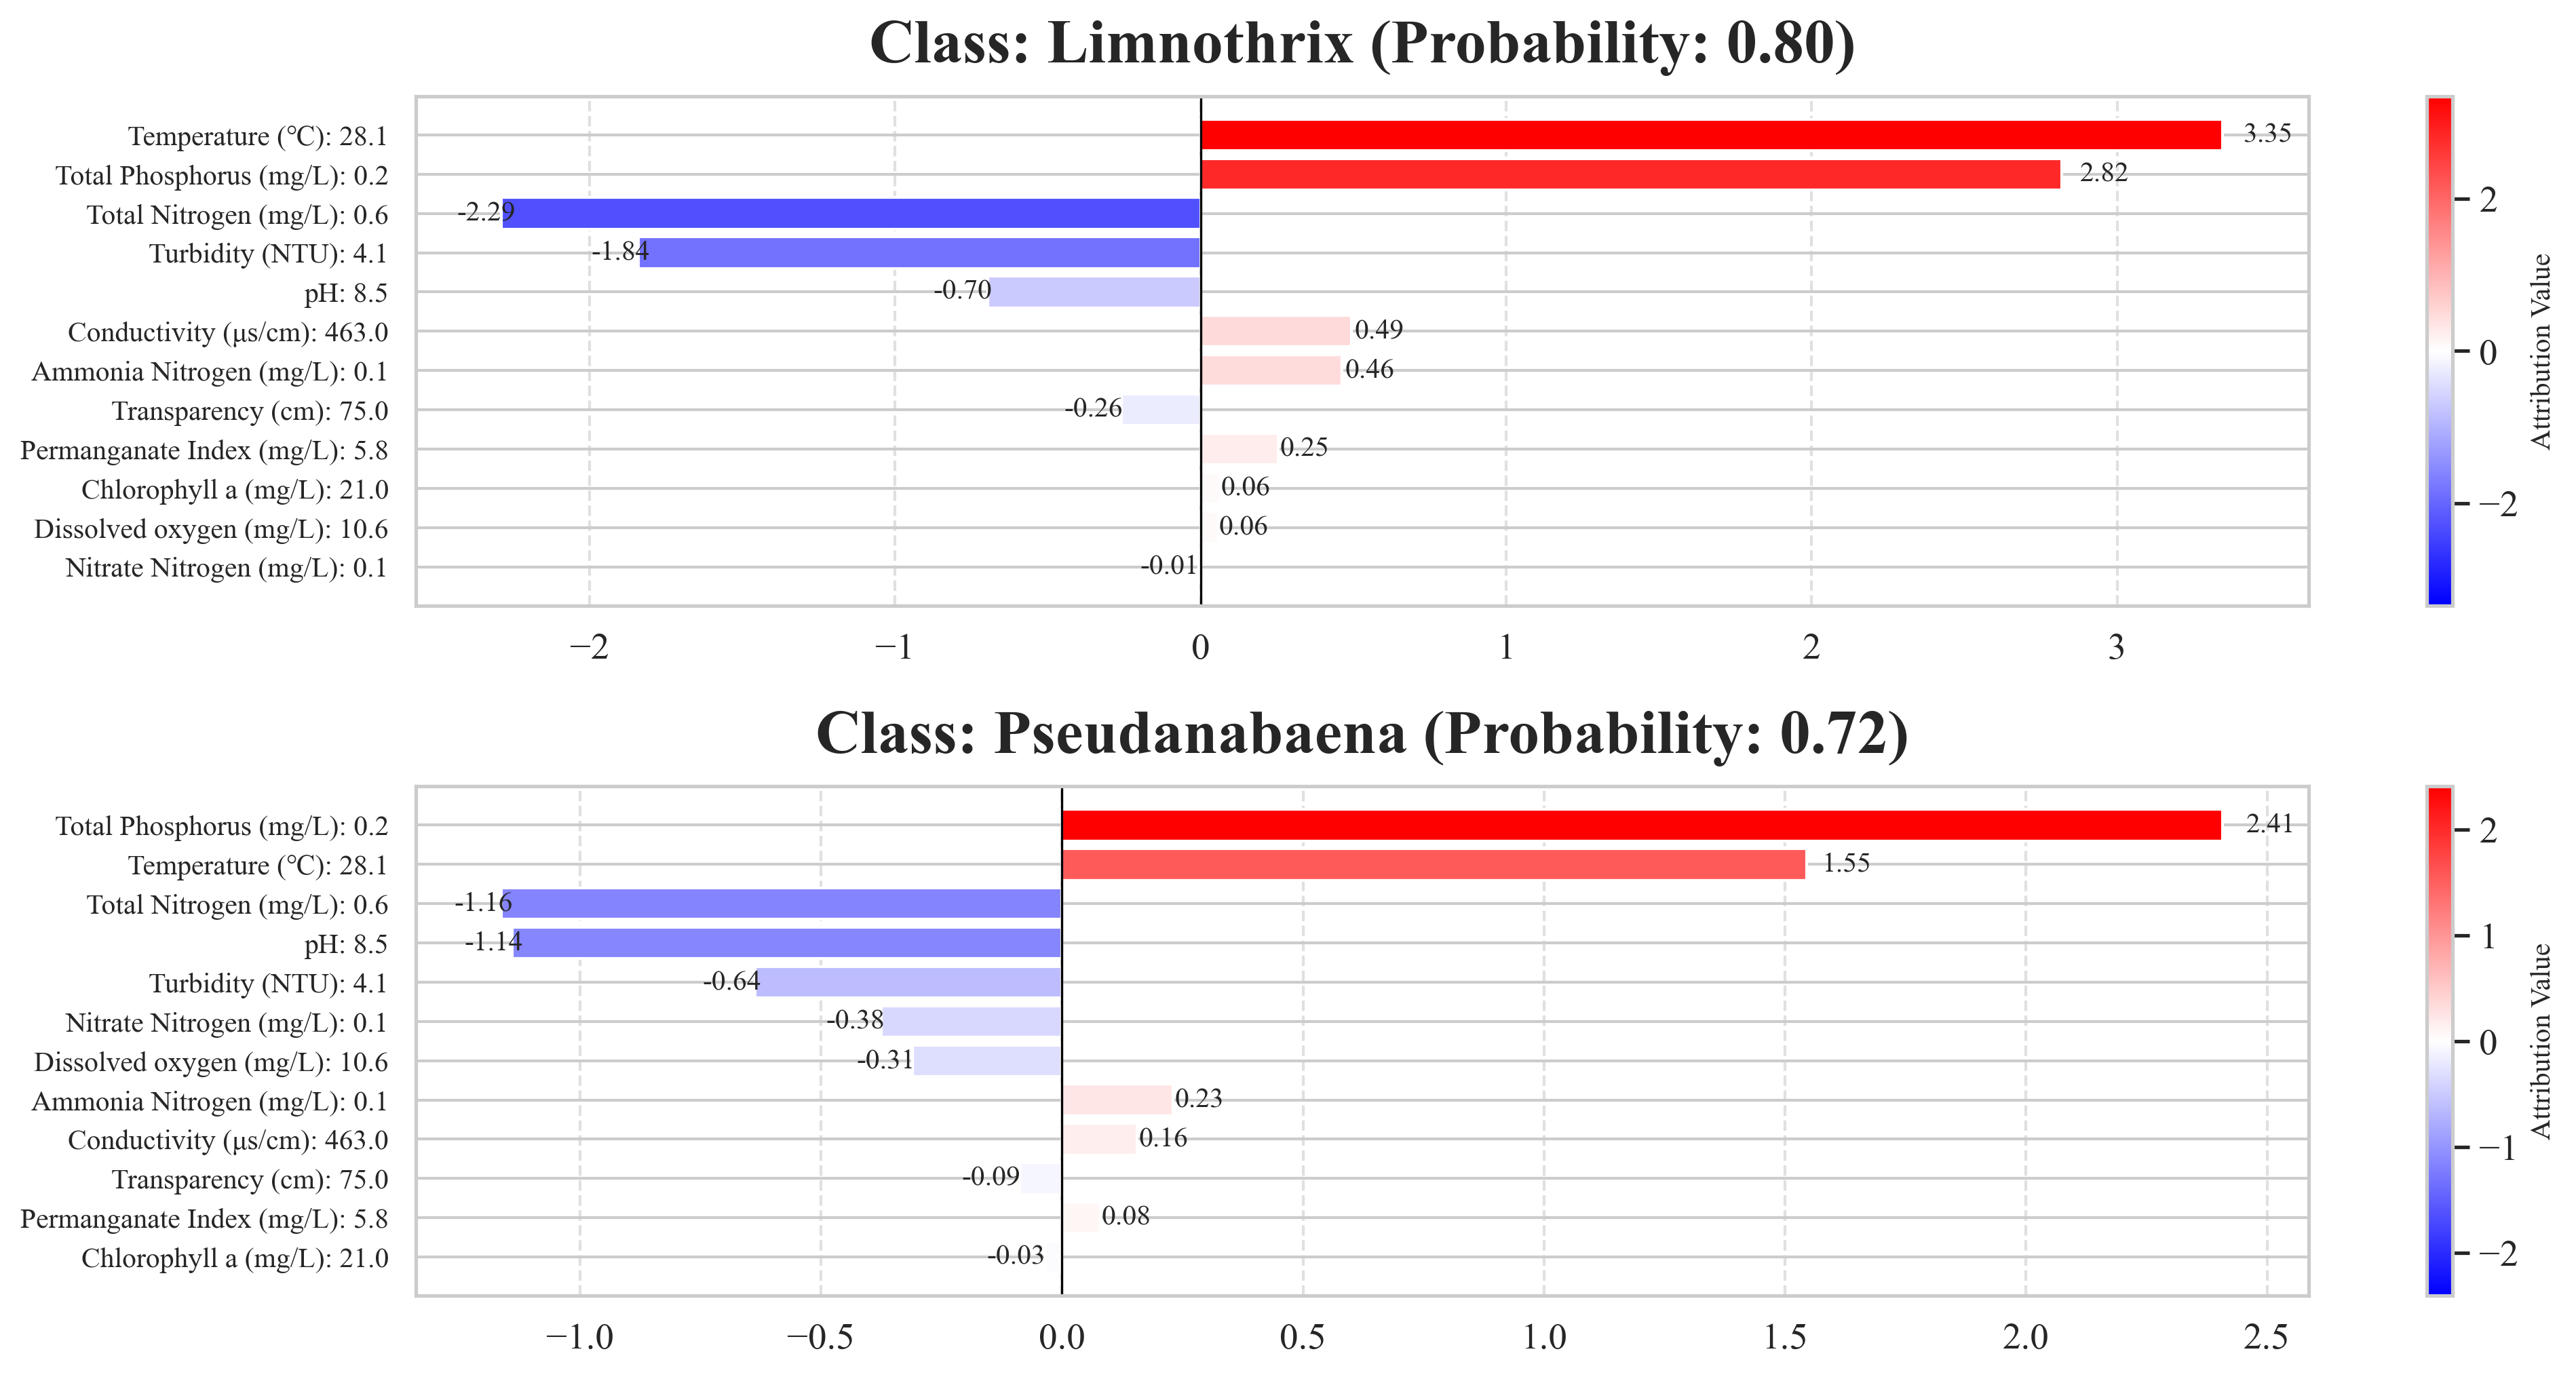

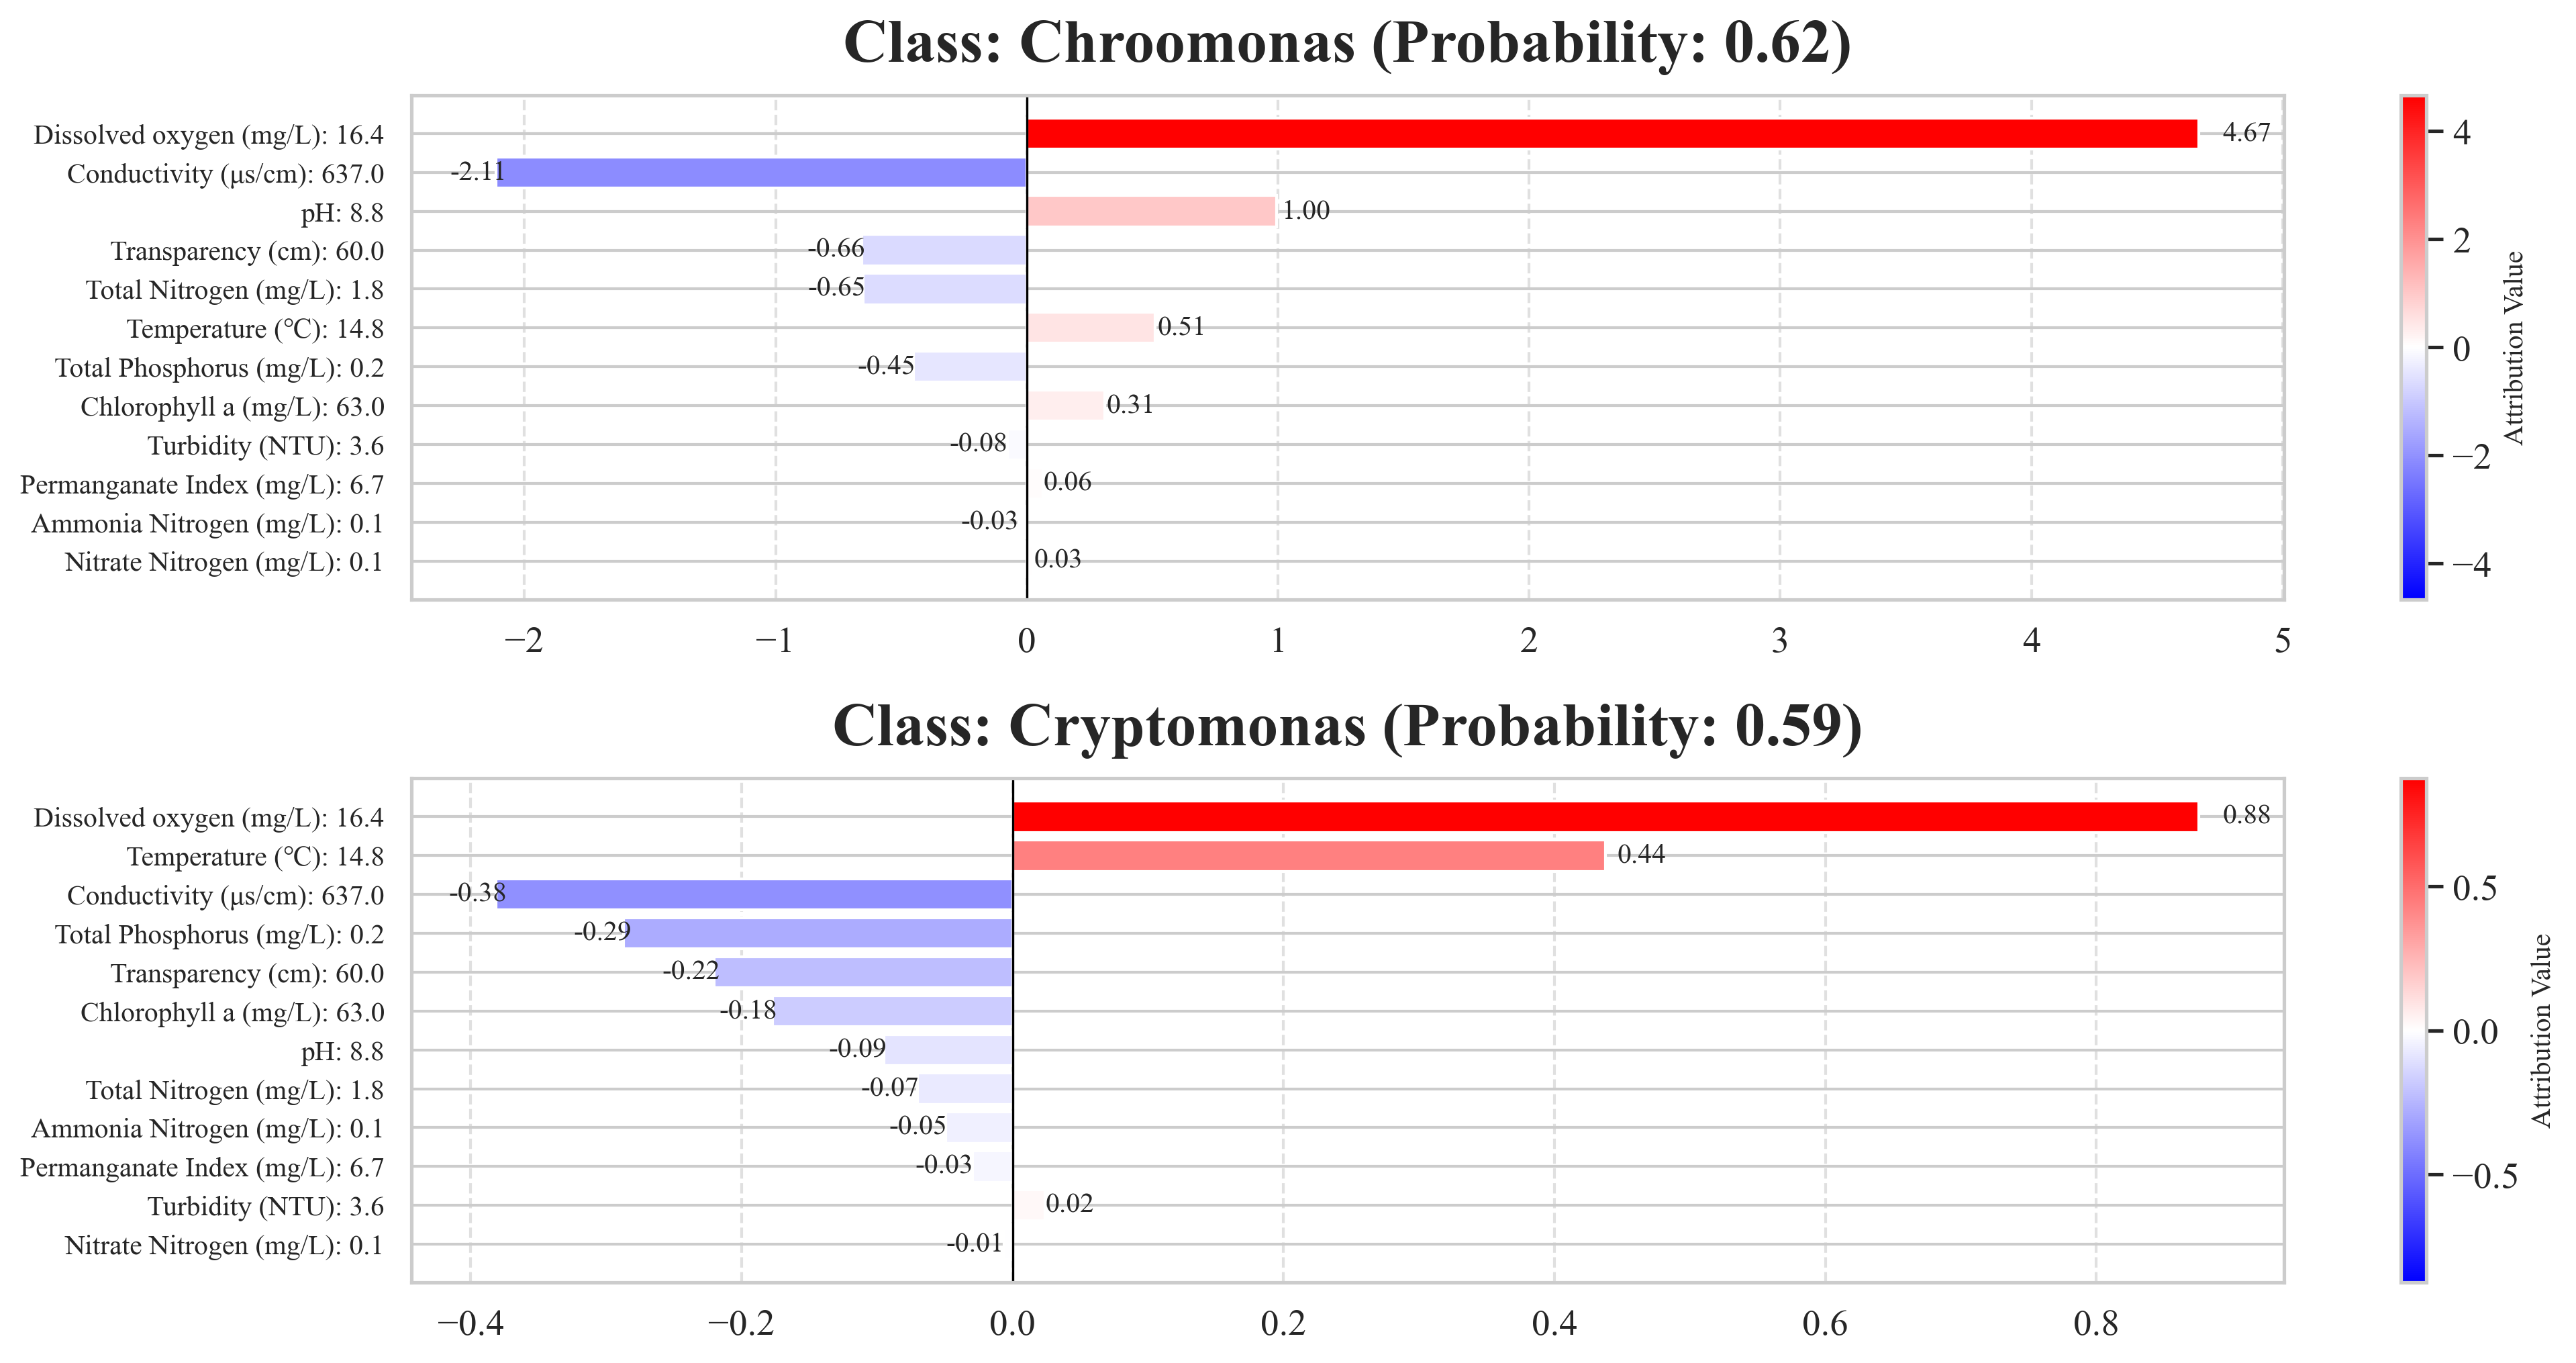

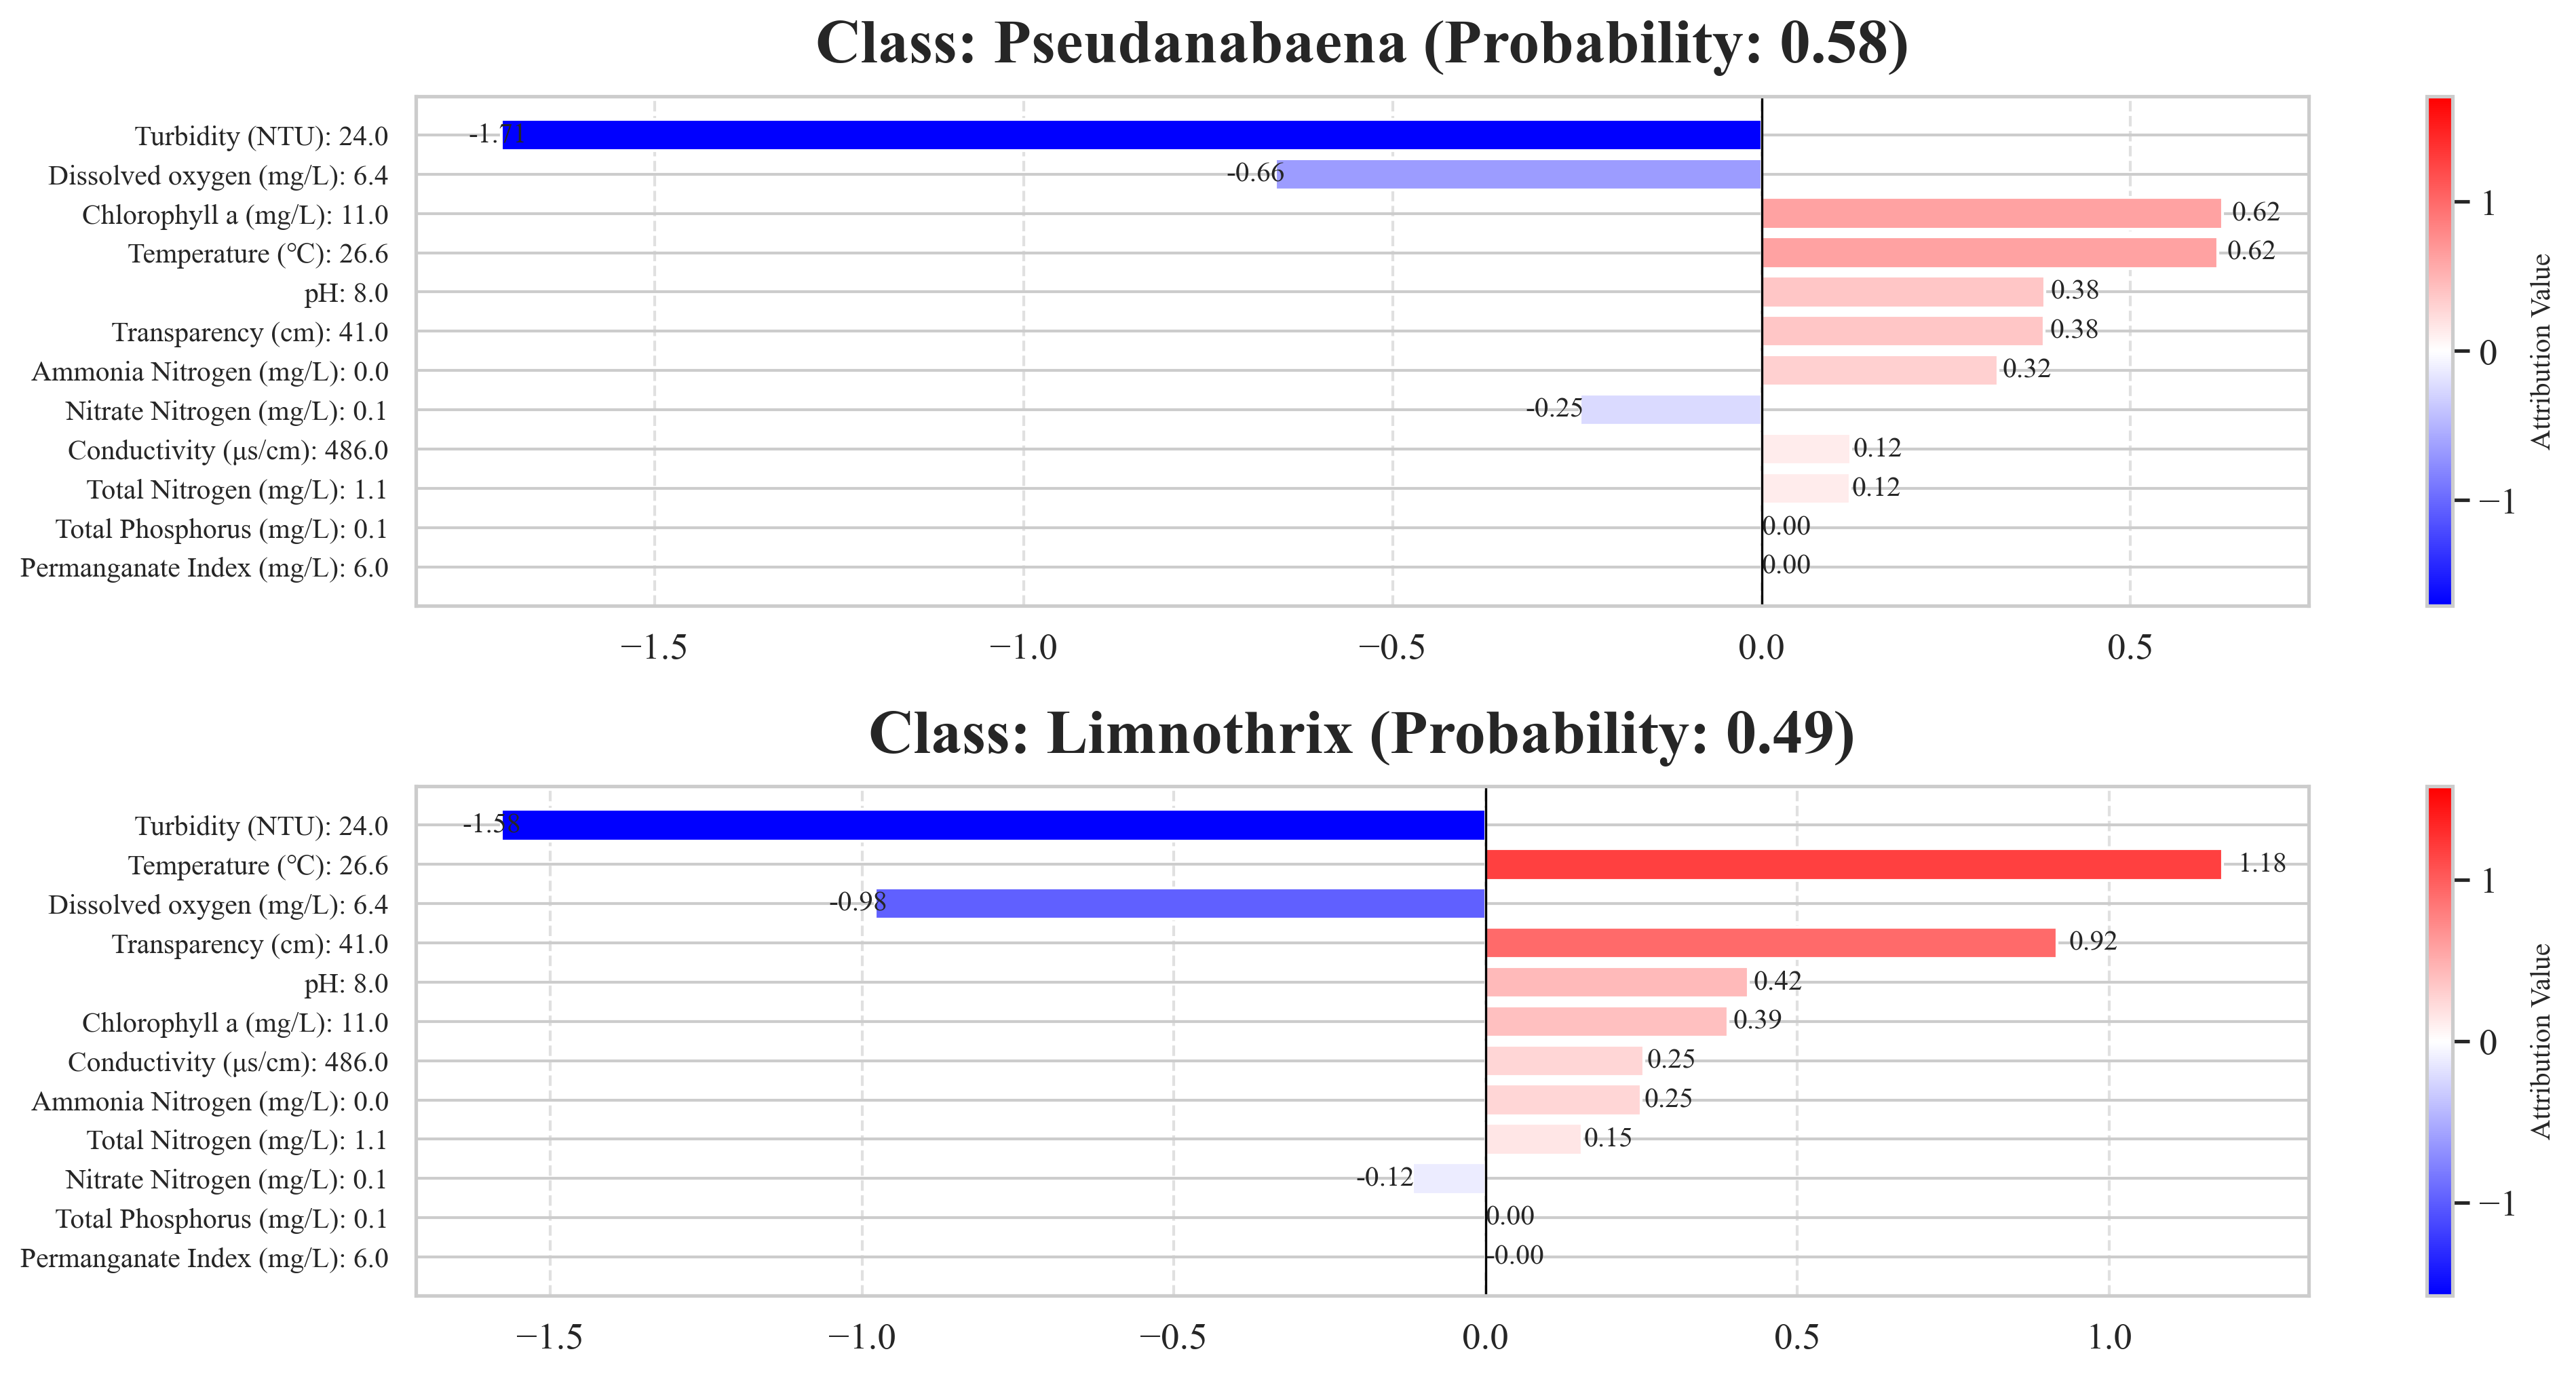

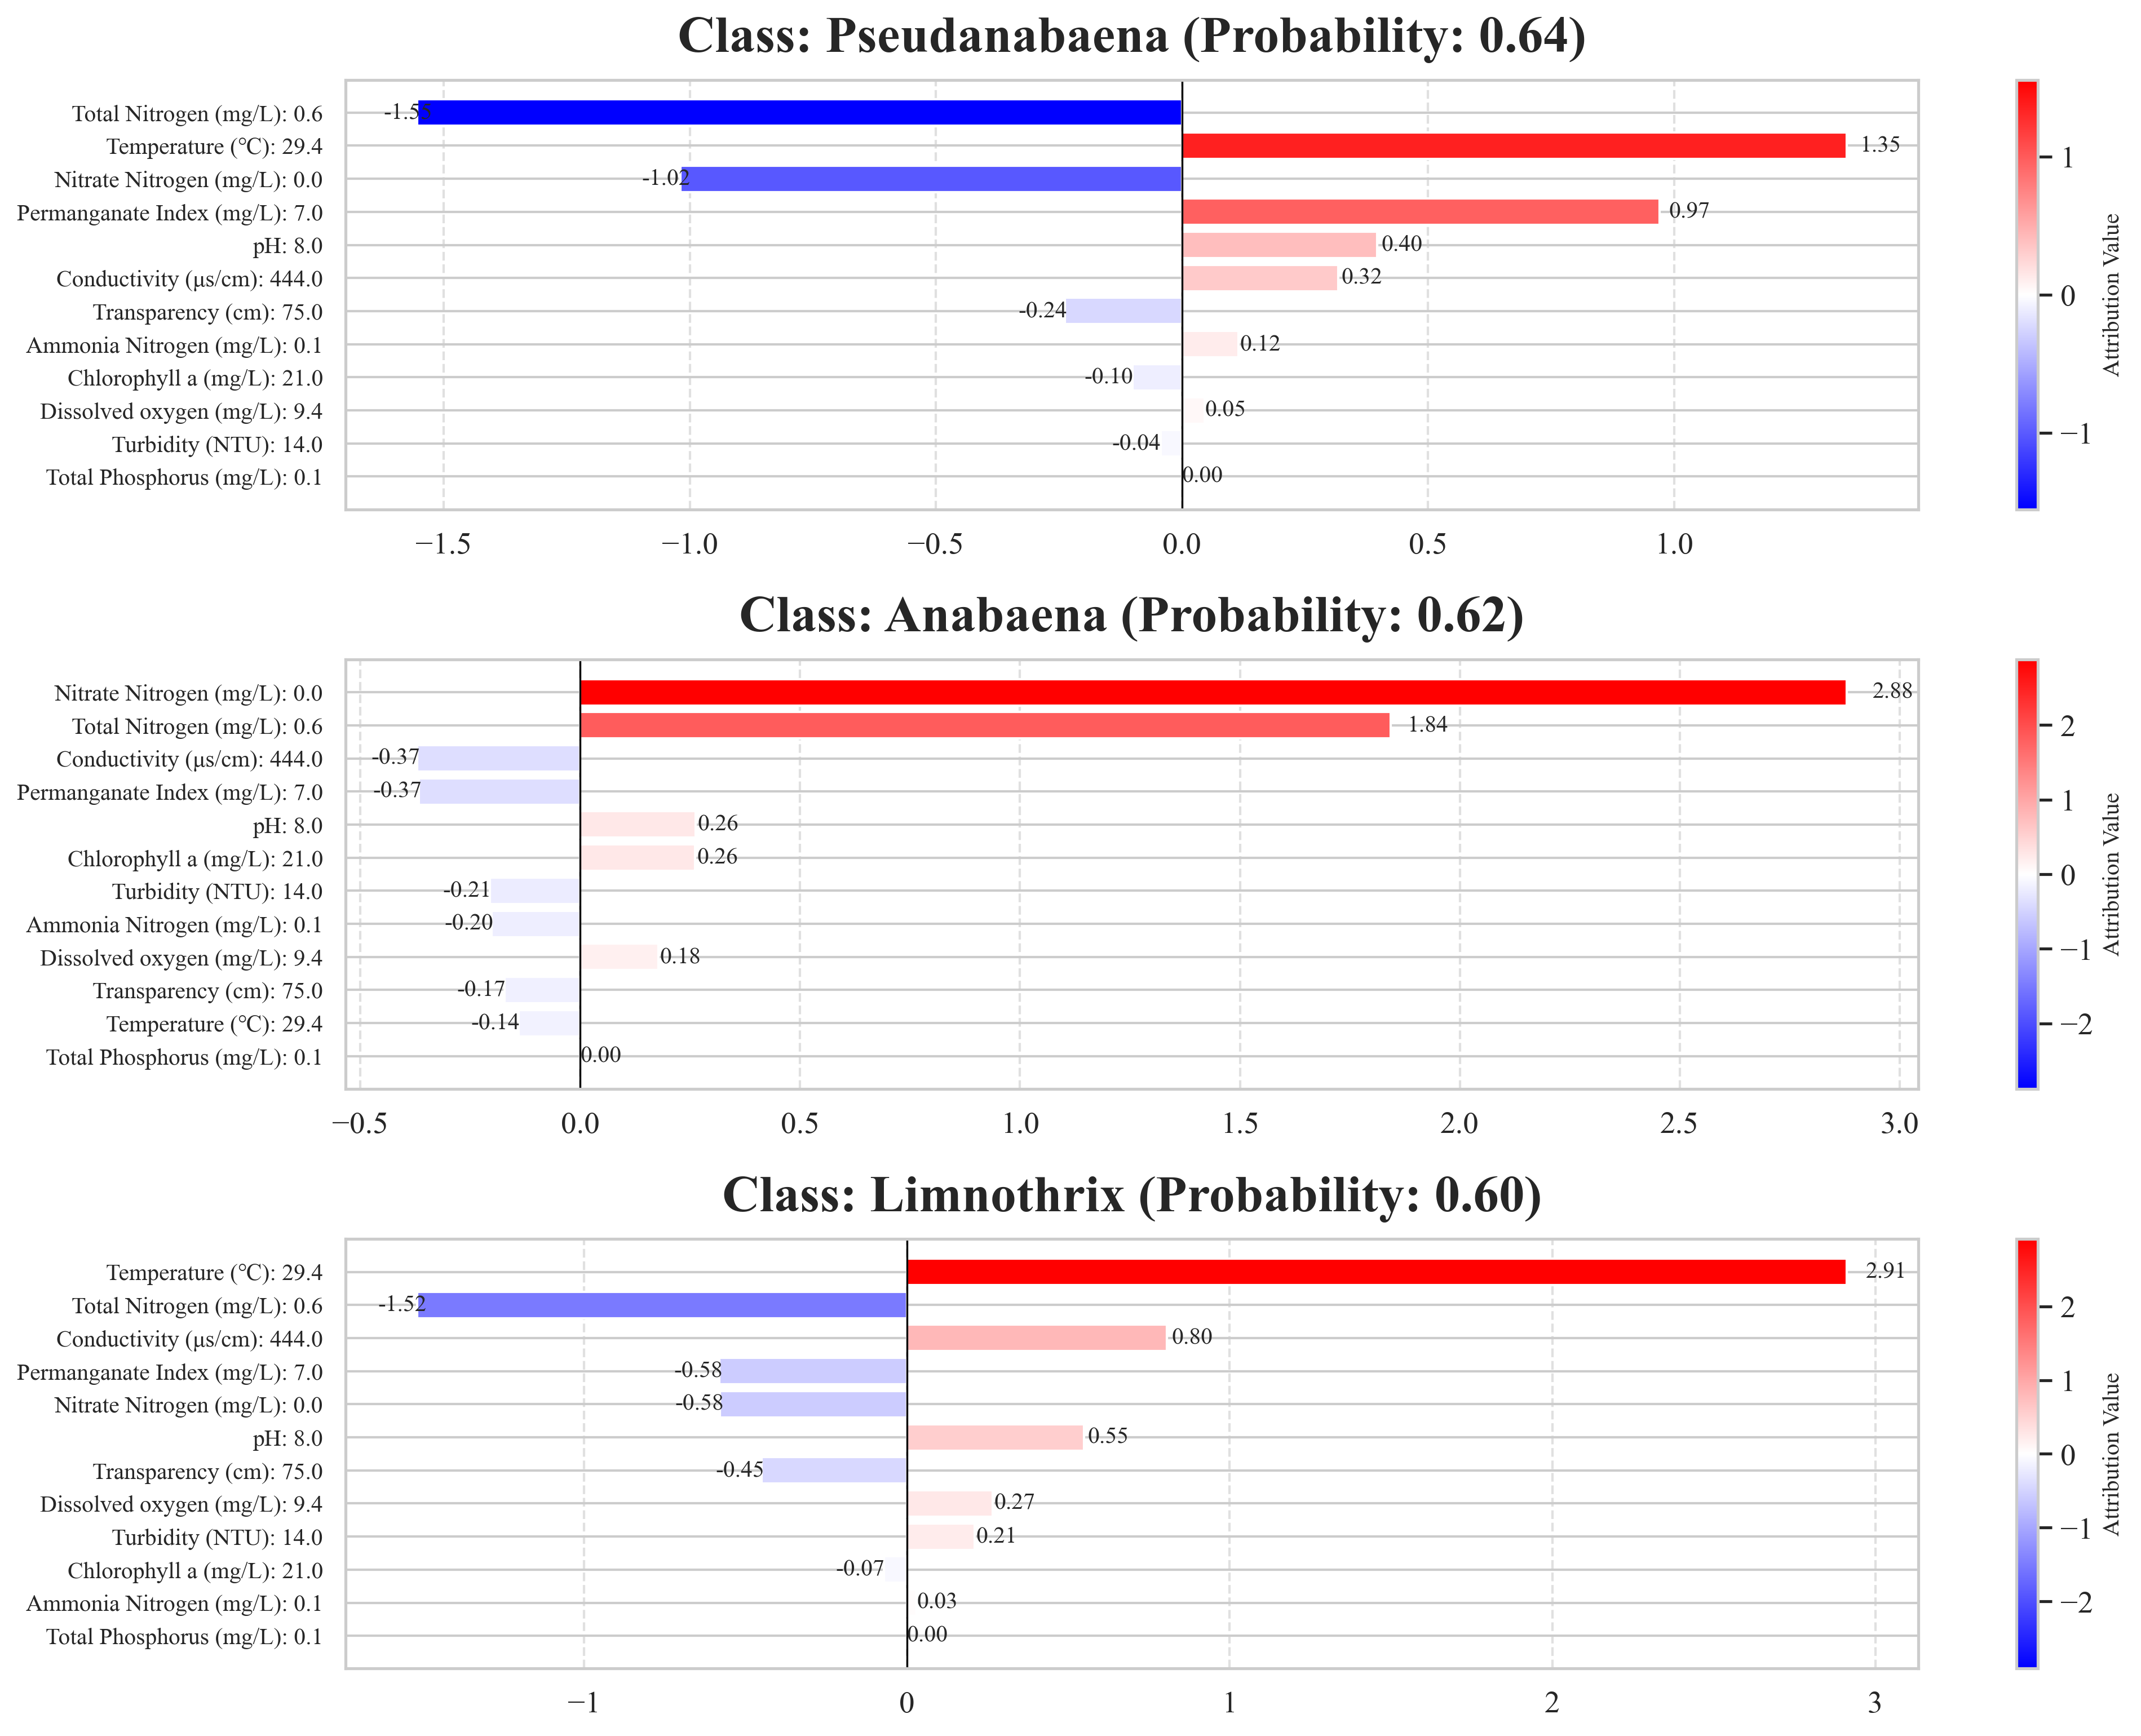

In [12]:
for i in range(len(X_test)):
    plot_sample_attribution(i,inputs[i], species_model, ig, class_names,
                           feature_names, device, x_scaler,  # 传入归一化器
                           top_k=12)

In [25]:
x_scaler.inverse_transform(X_test)


array([[2.080e+01, 8.400e+00, 1.016e+01, 5.010e+02, 2.300e+00, 2.060e+02,
        5.300e+00, 2.350e-01, 2.000e-02, 9.800e-01, 2.710e-01, 2.000e+01],
       [2.360e+01, 7.700e+00, 7.860e+00, 4.880e+02, 8.100e+00, 9.000e+01,
        6.400e+00, 5.200e-02, 7.000e-02, 5.700e-01, 9.000e-03, 2.200e+01],
       [2.100e+01, 8.200e+00, 8.170e+00, 4.010e+02, 1.300e+01, 5.800e+01,
        5.600e+00, 1.020e-01, 1.200e-01, 1.230e+00, 6.440e-01, 9.000e+00],
       [2.470e+01, 7.800e+00, 6.820e+00, 4.890e+02, 1.100e+01, 7.700e+01,
        4.900e+00, 2.930e-01, 6.000e-02, 7.100e-01, 1.660e-01, 1.300e+01],
       [1.110e+01, 8.400e+00, 1.020e+01, 6.610e+02, 1.100e+01, 6.800e+01,
        2.800e+00, 1.910e-01, 1.300e-01, 1.480e+00, 1.090e+00, 2.800e+01],
       [1.930e+01, 8.300e+00, 1.012e+01, 5.650e+02, 3.100e+00, 1.300e+02,
        6.000e+00, 5.000e-02, 4.000e-02, 1.070e+00, 5.960e-01, 2.700e+01],
       [3.000e+01, 8.500e+00, 1.013e+01, 4.420e+02, 4.000e+00, 1.100e+02,
        5.700e+00, 5.100e-02, 3.